# 📱 The Instagram Behavioral Genome
## Decoding 1 Million User Profiles: Where Digital Habits Meet Real Life

**Dataset:** 1M synthetic Instagram user profiles (2025–2026) with 57 features spanning demographics, lifestyle, health metrics, and platform engagement.

**Approach:** This notebook is structured as an investigation. Each section poses a question, runs the analysis, and states what the data tells us.

---

### Table of Contents
1. **Who are these 1M users?** — Profiling & demographics
2. **Where does all the screen time actually go?** — Time allocation breakdown
3. **Can we detect doom-scrollers from their behavioral fingerprint?** — Building a composite addiction index
4. **Does doom-scrolling actually predict worse mental health?** — Validating against stress, happiness, sleep
5. **Is there a tipping point where usage goes from fine to harmful?** — Inflection point analysis
6. **What distinct user personas emerge from the data?** — Clustering & radar profiles
7. **Do healthier lifestyles buffer against compulsive usage?** — Health × behavior intersection
8. **What features most strongly predict someone's happiness?** — Feature importance


---
## ⚙️ Environment Setup

- Load all required libraries
- Define the master light theme palette and helper functions
- These get reused across every chart in the notebook


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ══════════════════════════════════════════════════════════════
# MASTER LIGHT THEME
# ══════════════════════════════════════════════════════════════

P = {
    'bg':       '#FFFFFF',
    'card':     '#F8F9FA',
    'grid':     '#E9ECEF',
    'border':   '#DEE2E6',
    'text':     '#212529',
    'muted':    '#6C757D',
    'subtle':   '#ADB5BD',

    # Instagram-inspired accent palette
    'purple':   '#833AB4',
    'magenta':  '#C13584',
    'red':      '#E1306C',
    'orange':   '#F56040',
    'gold':     '#FCAD03',
    'yellow':   '#FFDC80',

    # Functional accents
    'blue':     '#3A86FF',
    'cyan':     '#00B4D8',
    'mint':     '#06D6A0',
    'pink':     '#EF476F',
    'coral':    '#FF6B6B',
    'lavender': '#B8B8FF',
}

IG_GRAD = [P['purple'], P['magenta'], P['red'], P['orange'], P['gold']]
ACCENT_SEQ = [P['blue'], P['mint'], P['purple'], P['coral'], P['cyan'], P['gold']]

plt.rcParams.update({
    'figure.facecolor':     P['bg'],
    'axes.facecolor':       P['card'],
    'axes.edgecolor':       P['border'],
    'axes.labelcolor':      P['text'],
    'text.color':           P['text'],
    'xtick.color':          P['muted'],
    'ytick.color':          P['muted'],
    'grid.color':           P['grid'],
    'grid.alpha':           0.6,
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'figure.titlesize':     18,
    'figure.titleweight':   'bold',
    'legend.facecolor':     P['card'],
    'legend.edgecolor':     P['border'],
    'legend.fontsize':      9,
    'savefig.facecolor':    P['bg'],
    'savefig.edgecolor':    P['bg'],
    'axes.spines.top':      False,
    'axes.spines.right':    False,
})

def section_footer(fig):
    fig.text(0.99, 0.01, 'Instagram Behavioral Genome · 1M Users',
             fontsize=7, color=P['subtle'], alpha=0.5,
             ha='right', va='bottom', style='italic')

print("✅ Light theme loaded")


✅ Light theme loaded


---
## 📥 Data Ingestion

- Load both CSV files from the Kaggle input directory
- If they share the same schema, concatenate them into one DataFrame
- Otherwise, use the larger file
- Quick shape and memory check


In [2]:
data_dir = '/kaggle/input/social-media-user-analysis/'
files = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
print(f"📂 Files found: {files}")

dfs = []
for f in files:
    print(f"  ⏳ Loading {os.path.basename(f)}...")
    tmp = pd.read_csv(f)
    print(f"     → {tmp.shape[0]:,} rows × {tmp.shape[1]} cols")
    dfs.append(tmp)

if len(dfs) == 2 and list(dfs[0].columns) == list(dfs[1].columns):
    df = pd.concat(dfs, ignore_index=True)
    print(f"\n🔗 Combined both files (identical schemas)")
elif len(dfs) == 2:
    df = max(dfs, key=len)
    print(f"\n⚠️ Different schemas — using the larger file")
else:
    df = dfs[0]

print(f"\n🔢 Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory:  {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"\n📋 Columns:\n{list(df.columns)}")
df.head(3)


📂 Files found: ['/kaggle/input/social-media-user-analysis/instagram_usage_lifestyle.csv', '/kaggle/input/social-media-user-analysis/instagram_users_lifestyle.csv']
  ⏳ Loading instagram_usage_lifestyle.csv...


     → 1,547,896 rows × 58 cols
  ⏳ Loading instagram_users_lifestyle.csv...


     → 1,547,896 rows × 58 cols



🔗 Combined both files (identical schemas)

🔢 Final shape: 3,095,792 rows × 58 columns


💾 Memory:  4407.2 MB

📋 Columns:
['user_id', 'app_name', 'age', 'gender', 'country', 'urban_rural', 'income_level', 'employment_status', 'education_level', 'relationship_status', 'has_children', 'exercise_hours_per_week', 'sleep_hours_per_night', 'diet_quality', 'smoking', 'alcohol_frequency', 'perceived_stress_score', 'self_reported_happiness', 'body_mass_index', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'daily_steps_count', 'weekly_work_hours', 'hobbies_count', 'social_events_per_month', 'books_read_per_year', 'volunteer_hours_per_month', 'travel_frequency_per_year', 'daily_active_minutes_instagram', 'sessions_per_day', 'posts_created_per_week', 'reels_watched_per_day', 'stories_viewed_per_day', 'likes_given_per_day', 'comments_written_per_day', 'dms_sent_per_week', 'dms_received_per_week', 'ads_viewed_per_day', 'ads_clicked_per_day', 'time_on_feed_per_day', 'time_on_explore_per_day', 'time_on_messages_per_day', 'time_on_reels_per_day', 'followers_count', 'following_coun

,user_id,app_name,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,...,last_login_date,average_session_length_minutes,content_type_preference,preferred_content_theme,privacy_setting_level,two_factor_auth_enabled,biometric_login_used,linked_accounts_count,subscription_status,user_engagement_score
0,1,Instagram,51,Female,India,Rural,High,Retired,Bachelor’s,Single,...,2025-11-02,5.0,Mixed,Tech,Private,Yes,No,0,Free,7.83
1,2,Instagram,64,Female,United Kingdom,Urban,Middle,Full-time employed,Other,Divorced,...,2025-03-22,14.8,Photos,Fashion,Public,No,No,3,Free,1.43
2,3,Instagram,41,Female,Canada,Urban,Middle,Student,Bachelor’s,In a relationship,...,2025-08-10,5.0,Mixed,Other,Public,Yes,Yes,1,Free,9.67


In [3]:
# Quick structural audit
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

print(f"Numeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"\nNull percentages (top 10):")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(10).round(2))
print(f"\nNumeric describe:")
df[num_cols].describe().round(2).T


Numeric columns: 38
Categorical columns: 20

Null percentages (top 10):


user_id                     0.0
followers_count             0.0
reels_watched_per_day       0.0
stories_viewed_per_day      0.0
likes_given_per_day         0.0
comments_written_per_day    0.0
dms_sent_per_week           0.0
dms_received_per_week       0.0
ads_viewed_per_day          0.0
ads_clicked_per_day         0.0
dtype: float64

Numeric describe:


,count,mean,std,min,25%,50%,75%,max
user_id,3095792.0,773948.50,446839.16,1.00,386974.75,773948.5,1160922.25,1547896.00
age,3095792.0,38.99,15.29,13.00,26.00,39.0,52.00,65.00
exercise_hours_per_week,3095792.0,7.14,3.99,0.00,4.00,6.6,9.70,24.10
sleep_hours_per_night,3095792.0,7.00,1.10,3.00,6.30,7.0,7.70,10.00
perceived_stress_score,3095792.0,19.99,11.83,0.00,10.00,20.0,30.00,40.00
self_reported_happiness,3095792.0,5.50,2.87,1.00,3.00,5.0,8.00,10.00
body_mass_index,3095792.0,25.00,3.98,15.00,22.30,25.0,27.70,45.00
blood_pressure_systolic,3095792.0,124.49,20.21,90.00,107.00,124.0,142.00,159.00
blood_pressure_diastolic,3095792.0,79.50,11.55,60.00,70.00,79.0,90.00,99.00
daily_steps_count,3095792.0,8000.10,89.40,7566.00,7940.00,8000.0,8060.00,8473.00


---
# Question 1: Who are these 1 million users?

**What we're looking at:**
- Age distribution segmented by generation (Gen Z, Millennial, Gen X, Boomer)
- Gender split and geographic spread (top countries)
- Income, education, employment, and urban/rural breakdowns
- How each demographic segment maps to Instagram engagement

**Why it matters:** Before we can find behavioral patterns, we need to understand the population we're working with. Skewed demographics would bias every downstream insight.


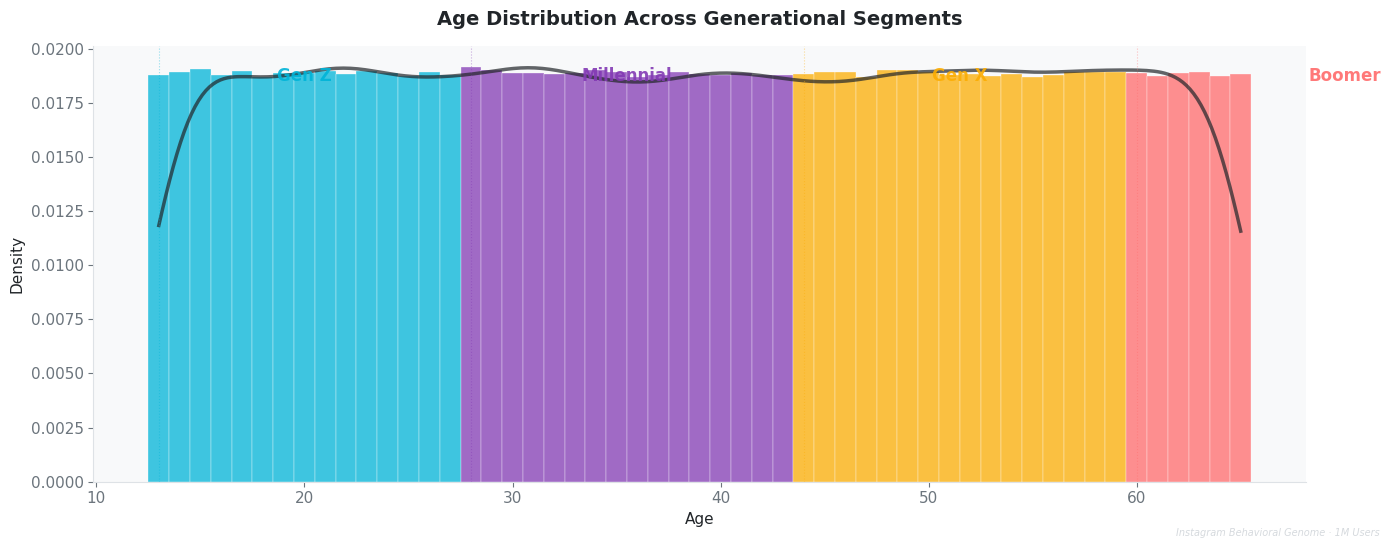

In [4]:
# ── Age Distribution with Generational Segments ───────────────
fig, ax = plt.subplots(figsize=(14, 5.5))

age_data = df['age'].dropna()
bins = np.arange(age_data.min() - 0.5, age_data.max() + 1.5, 1)
n, bins_out, patches = ax.hist(age_data, bins=bins, density=True,
                                alpha=0.75, edgecolor='white', linewidth=0.3)

gen_bands = [
    (13, 27, 'Gen Z',      P['cyan']),
    (28, 43, 'Millennial',  P['purple']),
    (44, 59, 'Gen X',       P['gold']),
    (60, 80, 'Boomer',      P['coral']),
]
for patch, left in zip(patches, bins_out[:-1]):
    age_val = left + 0.5
    for lo, hi, _, col in gen_bands:
        if lo <= age_val <= hi:
            patch.set_facecolor(col)
            break

# KDE overlay
x_kde = np.linspace(age_data.min(), age_data.max(), 300)
kde = gaussian_kde(age_data.sample(min(50000, len(age_data)), random_state=42))
ax.plot(x_kde, kde(x_kde), color=P['text'], lw=2.5, alpha=0.7)

for lo, hi, label, col in gen_bands:
    mid = (lo + hi) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.92, label, ha='center', fontsize=12,
            fontweight='bold', color=col, alpha=0.9)
    ax.axvline(lo, color=col, ls=':', lw=0.8, alpha=0.4)

ax.set_title('Age Distribution Across Generational Segments', pad=15)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** The age distribution tells us about the population balance. Look for whether Gen Z dominates (which would explain high reels consumption downstream) or if it's more evenly spread. Any sharp drop-offs at certain ages may indicate synthetic generation boundaries.


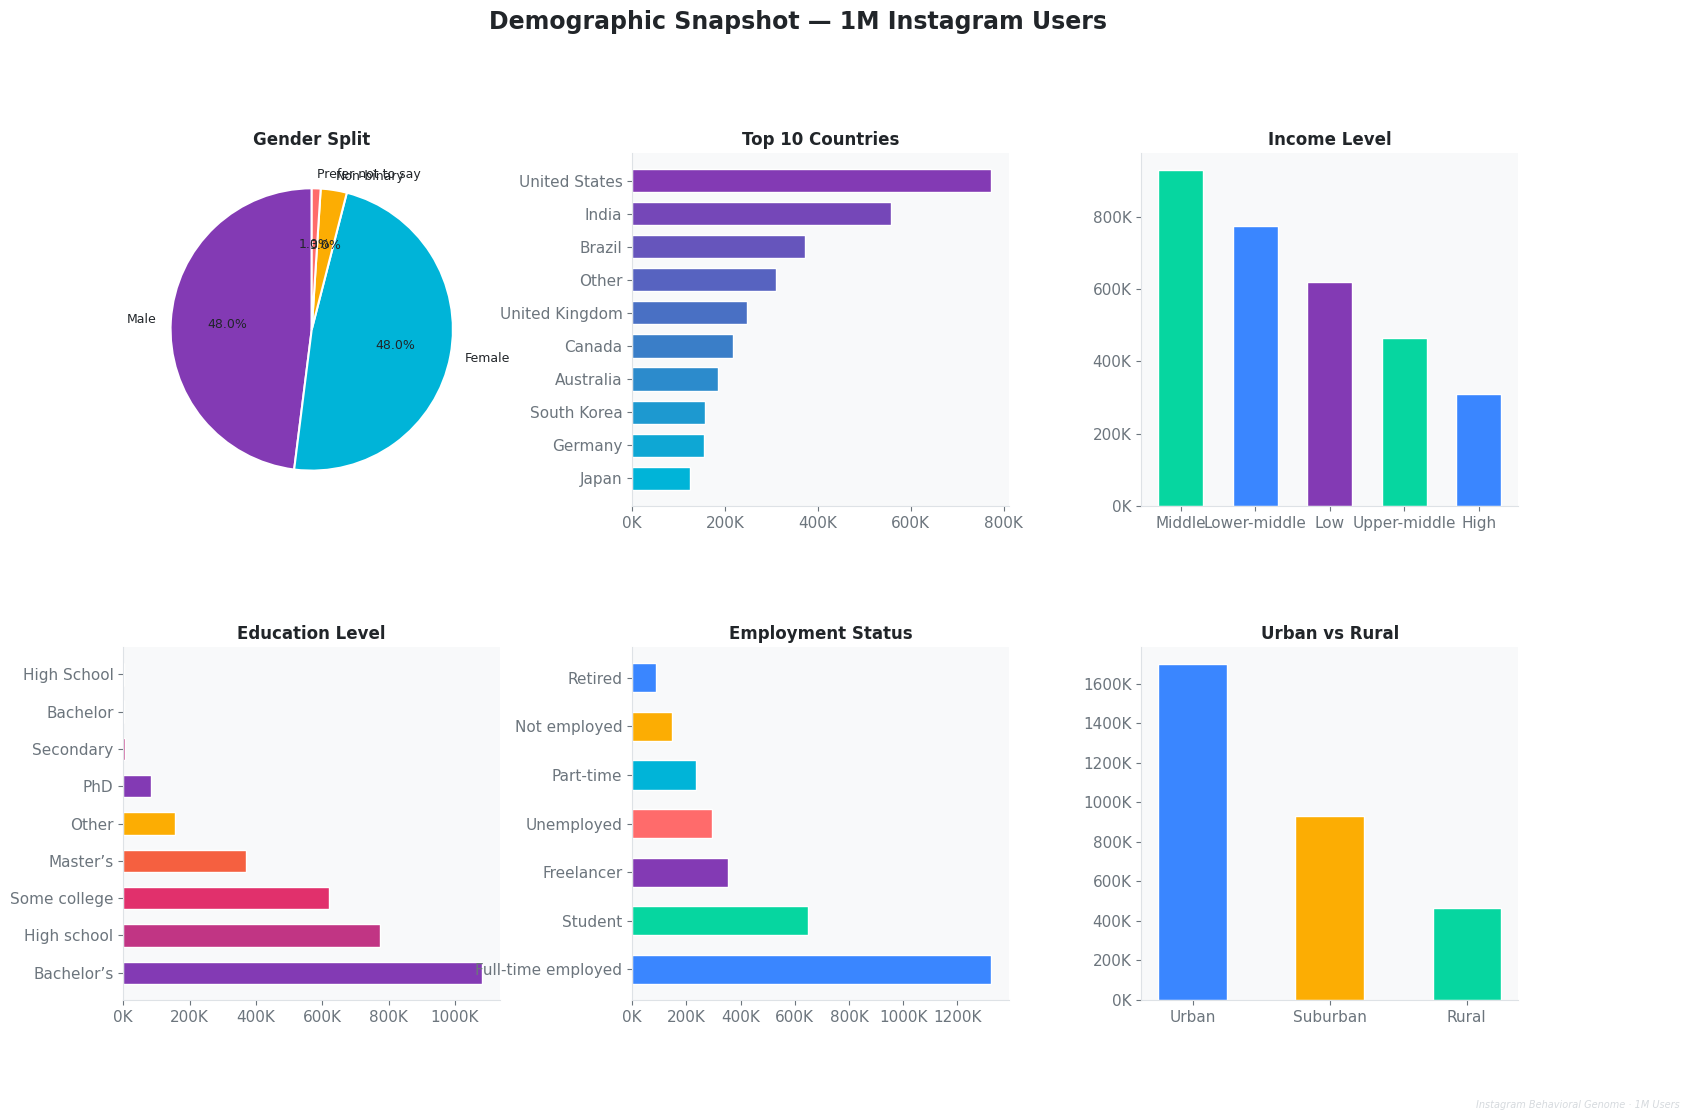

In [5]:
# ── 6-Panel Demographic Overview ──────────────────────────────
fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# 1 — Gender split
ax1 = fig.add_subplot(gs[0, 0])
if 'gender' in df.columns:
    counts = df['gender'].value_counts()
    colors_g = [P['purple'], P['cyan'], P['gold'], P['coral']]
    ax1.pie(counts.values, labels=counts.index, autopct='%1.1f%%',
            colors=colors_g[:len(counts)], startangle=90,
            textprops={'fontsize': 9}, wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
    ax1.set_title('Gender Split', fontsize=12)

# 2 — Top 10 countries
ax2 = fig.add_subplot(gs[0, 1])
if 'country' in df.columns:
    top_c = df['country'].value_counts().head(10)
    cmap_c = LinearSegmentedColormap.from_list('', [P['cyan'], P['purple']])
    colors_c = [cmap_c(i / 9) for i in range(10)]
    ax2.barh(top_c.index[::-1], top_c.values[::-1],
             color=colors_c, edgecolor='white', height=0.7)
    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
    ax2.set_title('Top 10 Countries', fontsize=12)

# 3 — Income level
ax3 = fig.add_subplot(gs[0, 2])
if 'income_level' in df.columns:
    inc = df['income_level'].value_counts()
    ax3.bar(inc.index, inc.values, color=[P['mint'], P['blue'], P['purple']][:len(inc)],
            edgecolor='white', width=0.6)
    ax3.set_title('Income Level', fontsize=12)
    ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

# 4 — Education
ax4 = fig.add_subplot(gs[1, 0])
if 'education_level' in df.columns:
    edu = df['education_level'].value_counts()
    ax4.barh(edu.index, edu.values,
             color=[IG_GRAD[i % len(IG_GRAD)] for i in range(len(edu))],
             edgecolor='white', height=0.6)
    ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
    ax4.set_title('Education Level', fontsize=12)

# 5 — Employment
ax5 = fig.add_subplot(gs[1, 1])
if 'employment_status' in df.columns:
    emp = df['employment_status'].value_counts()
    ax5.barh(emp.index, emp.values,
             color=[ACCENT_SEQ[i % len(ACCENT_SEQ)] for i in range(len(emp))],
             edgecolor='white', height=0.6)
    ax5.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
    ax5.set_title('Employment Status', fontsize=12)

# 6 — Urban / Rural
ax6 = fig.add_subplot(gs[1, 2])
if 'urban_rural' in df.columns:
    ur = df['urban_rural'].value_counts()
    ax6.bar(ur.index, ur.values, color=[P['blue'], P['gold'], P['mint']][:len(ur)],
            edgecolor='white', width=0.5)
    ax6.set_title('Urban vs Rural', fontsize=12)
    ax6.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

fig.suptitle('Demographic Snapshot — 1M Instagram Users',
             fontsize=17, fontweight='bold', color=P['text'], y=1.01)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** Review the demographic panels above for balance. If gender or geography is skewed, we'll need to keep that in mind when interpreting behavioral correlations. Even splits suggest the synthetic generation was well-calibrated.


---
# Question 2: Where does all the screen time actually go?

**What we're looking at:**
- How total daily active minutes break down across Instagram's four surfaces: Feed, Explore, Reels, Messages
- KDE ridge plots for each surface showing distributional shape
- A stacked composition view: what percentage of each user's time goes where?

**Why it matters:** "Screen time" is a blunt metric. A user spending 60 minutes chatting in DMs is fundamentally different from one spending 60 minutes on the Reels feed. This decomposition is the foundation for the doom-scroll index we build next.


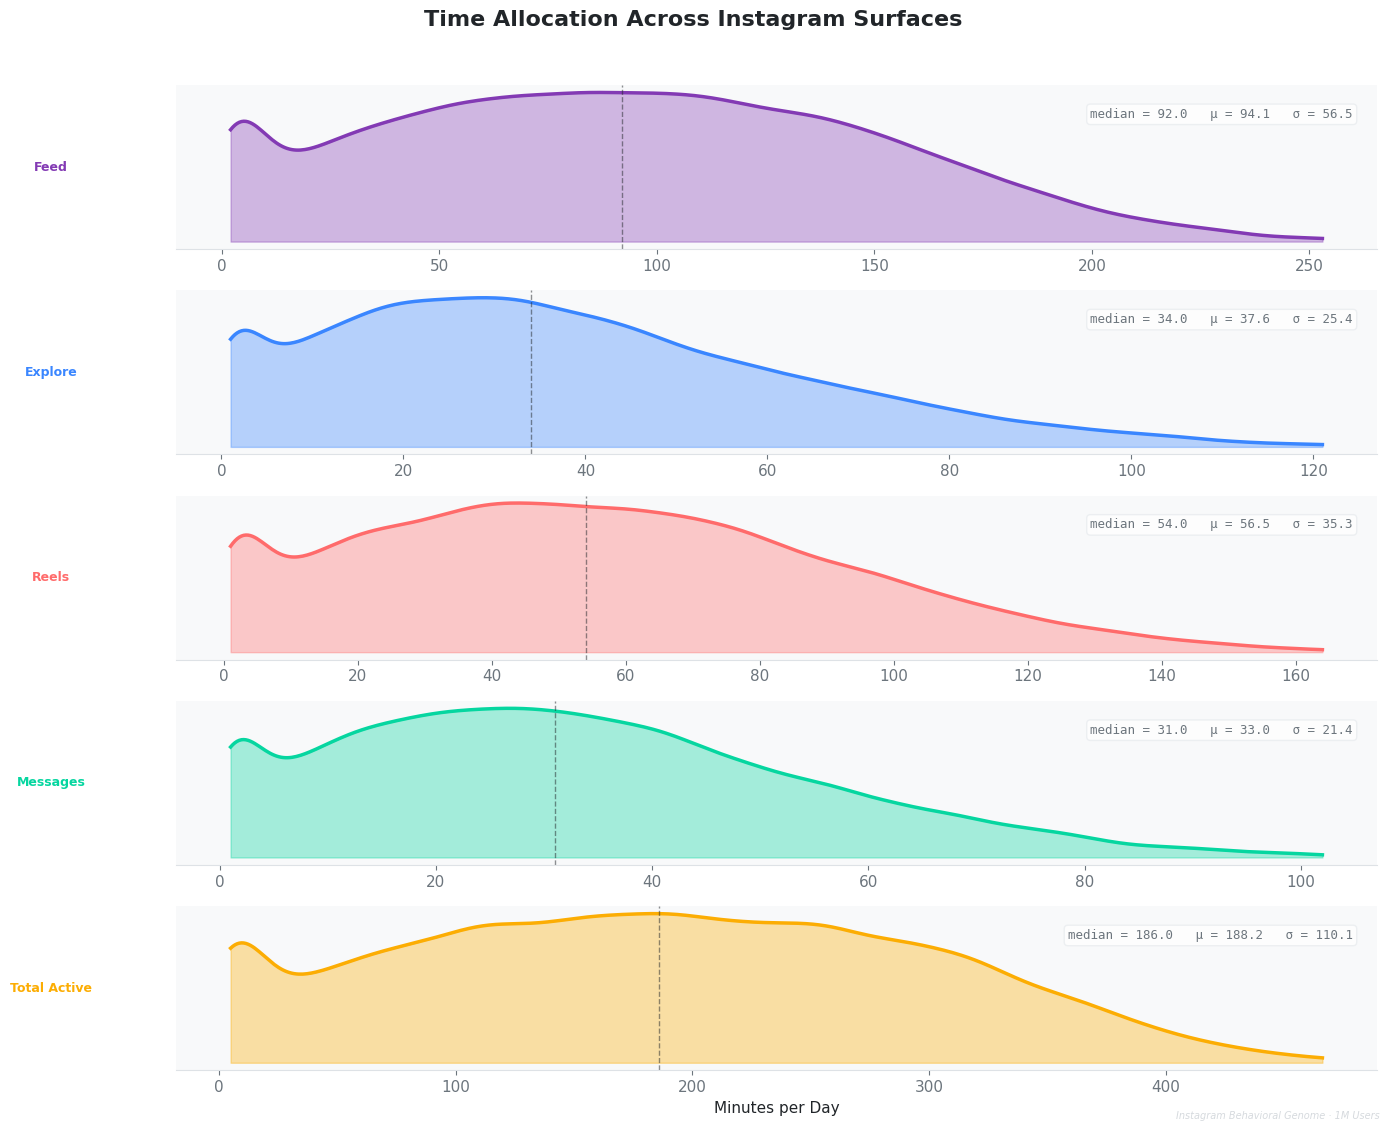

In [6]:
# ── Time Allocation Ridge Plot ─────────────────────────────────
time_cols = ['time_on_feed_per_day', 'time_on_explore_per_day',
             'time_on_reels_per_day', 'time_on_messages_per_day',
             'daily_active_minutes_instagram']
avail_time = [c for c in time_cols if c in df.columns]

fig, axes = plt.subplots(len(avail_time), 1, figsize=(14, 2.2 * len(avail_time)))

colors_ridge = [P['purple'], P['blue'], P['coral'], P['mint'], P['gold']]

for i, col in enumerate(avail_time):
    ax = axes[i]
    data = df[col].dropna()

    x_range = np.linspace(data.quantile(0.002), data.quantile(0.998), 500)
    kde = gaussian_kde(data.sample(min(50000, len(data)), random_state=42))
    density = kde(x_range)

    ax.fill_between(x_range, density, alpha=0.35, color=colors_ridge[i])
    ax.plot(x_range, density, color=colors_ridge[i], lw=2.5)

    med = data.median()
    ax.axvline(med, color=P['text'], ls='--', lw=1, alpha=0.5)
    ax.text(0.98, 0.8, f'median = {med:.1f}   μ = {data.mean():.1f}   σ = {data.std():.1f}',
            transform=ax.transAxes, ha='right', fontsize=9,
            color=P['muted'], family='monospace',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor=P['grid'], boxstyle='round,pad=0.3'))

    label = col.replace('time_on_', '').replace('_per_day', '').replace('daily_active_minutes_instagram', 'Total Active').replace('_', ' ').title()
    ax.set_ylabel(label, fontsize=9, rotation=0, labelpad=90, va='center', fontweight='bold',
                  color=colors_ridge[i])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)

axes[-1].set_xlabel('Minutes per Day')
fig.suptitle('Time Allocation Across Instagram Surfaces',
             fontsize=16, fontweight='bold', y=1.02)
section_footer(fig)
plt.tight_layout()
plt.show()


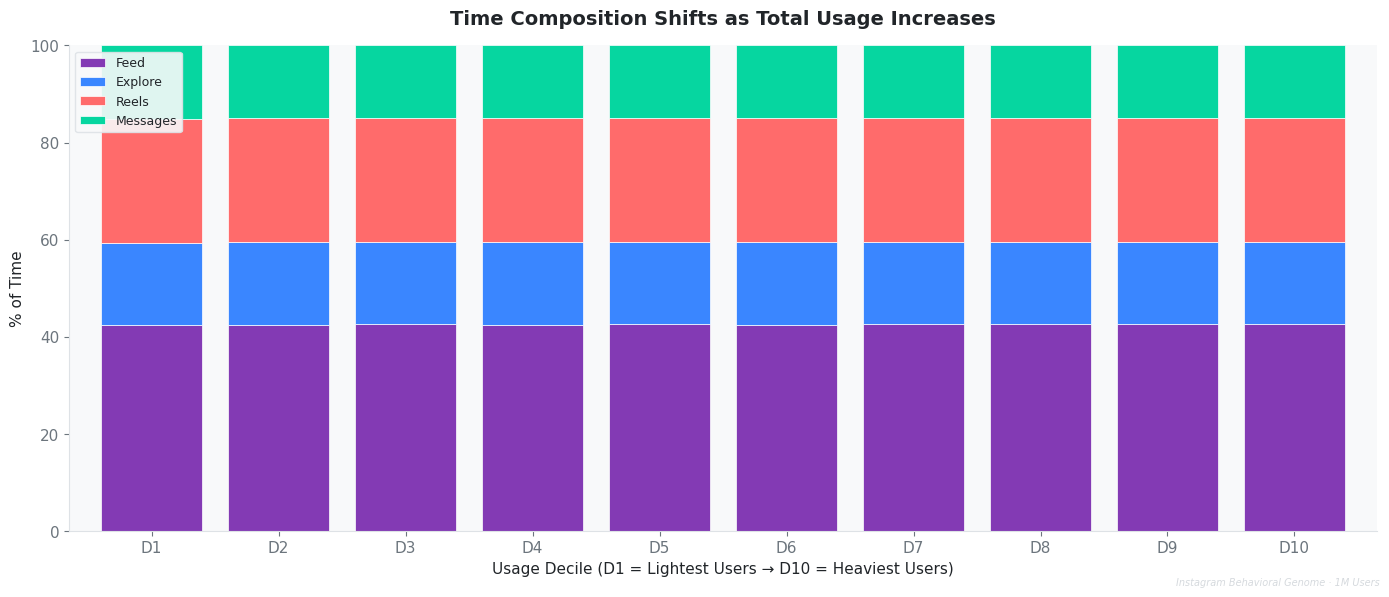

In [7]:
# ── Stacked Composition: Where does each user's time go? ──────
surface_cols = ['time_on_feed_per_day', 'time_on_explore_per_day',
                'time_on_reels_per_day', 'time_on_messages_per_day']
avail_surf = [c for c in surface_cols if c in df.columns]

if avail_surf:
    # Bin by total daily minutes
    df_temp = df[avail_surf + ['daily_active_minutes_instagram']].dropna().copy()
    df_temp['usage_bin'] = pd.qcut(df_temp['daily_active_minutes_instagram'], 10,
                                    labels=[f'D{i+1}' for i in range(10)], duplicates='drop')

    comp = df_temp.groupby('usage_bin')[avail_surf].mean()
    comp_pct = comp.div(comp.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(14, 6))
    colors_stack = [P['purple'], P['blue'], P['coral'], P['mint']]
    labels_stack = [c.replace('time_on_', '').replace('_per_day', '').replace('_', ' ').title()
                    for c in avail_surf]

    comp_pct.plot.bar(stacked=True, ax=ax, color=colors_stack[:len(avail_surf)],
                       edgecolor='white', linewidth=0.5, width=0.8)

    ax.set_ylabel('% of Time')
    ax.set_xlabel('Usage Decile (D1 = Lightest Users → D10 = Heaviest Users)')
    ax.set_title('Time Composition Shifts as Total Usage Increases', pad=15)
    ax.legend(labels_stack, loc='upper left', framealpha=0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylim(0, 100)
    section_footer(fig)
    plt.tight_layout()
    plt.show()


**📌 Insight:** Pay close attention to how the stacked composition shifts from D1 (lightest users) to D10 (heaviest users). If Reels and Feed dominate for heavy users while Messages stays flat, that confirms the heaviest usage is passive consumption — not social interaction. This is the behavioral signature we'll target with the doom-scroll index.


---
# Question 3: Can we detect doom-scrollers from their behavioral fingerprint?

**What we're looking at:**
- Building a **Doom-Scroll Index (DSI)** — a composite score from 0–100 that isolates passive, compulsive consumption
- High-weight inputs: reels time, feed time, session length, notification response rate
- Inverse-weight inputs: posts created, comments written, DMs sent (intentional usage lowers the score)
- Engineered ratios: passive/active ratio, session stickiness, engagement asymmetry
- Distribution of the DSI across the full population

**Why it matters:** "Daily active minutes" treats a content creator and a doom-scroller the same. This index separates passive consumption from active participation, giving us a much sharper lens for the wellbeing analysis that follows.


In [8]:
# ══════════════════════════════════════════════════════════════
# DOOM-SCROLL INDEX CONSTRUCTION
# ══════════════════════════════════════════════════════════════

# ── Step 1: Engineer ratio features ──────────────────────────
df_dsi = df.copy()

# Passive time (feed + reels + explore)
passive_cols = ['time_on_feed_per_day', 'time_on_reels_per_day', 'time_on_explore_per_day']
active_cols  = ['time_on_messages_per_day', 'posts_created_per_week', 'comments_written_per_day']

avail_passive = [c for c in passive_cols if c in df.columns]
avail_active  = [c for c in active_cols if c in df.columns]

if avail_passive:
    df_dsi['passive_time'] = df_dsi[avail_passive].sum(axis=1)
if avail_active:
    df_dsi['active_engagement'] = df_dsi[avail_active].sum(axis=1)

# Passive / Active ratio
if 'passive_time' in df_dsi.columns and 'active_engagement' in df_dsi.columns:
    df_dsi['passive_active_ratio'] = df_dsi['passive_time'] / (df_dsi['active_engagement'] + 1)

# Session stickiness = avg session length (long sessions = harder to disengage)
if 'average_session_length_minutes' in df_dsi.columns:
    df_dsi['session_stickiness'] = df_dsi['average_session_length_minutes']
elif 'daily_active_minutes_instagram' in df.columns and 'sessions_per_day' in df.columns:
    df_dsi['session_stickiness'] = df_dsi['daily_active_minutes_instagram'] / (df_dsi['sessions_per_day'] + 0.1)

# Consumption depth = reels watched per session
if 'reels_watched_per_day' in df.columns and 'sessions_per_day' in df.columns:
    df_dsi['consumption_depth'] = df_dsi['reels_watched_per_day'] / (df_dsi['sessions_per_day'] + 0.1)

# Engagement asymmetry = (likes + stories viewed) / (posts + comments + 1)
asym_consume = [c for c in ['likes_given_per_day', 'stories_viewed_per_day'] if c in df.columns]
asym_create  = [c for c in ['posts_created_per_week', 'comments_written_per_day'] if c in df.columns]
if asym_consume and asym_create:
    df_dsi['engagement_asymmetry'] = df_dsi[asym_consume].sum(axis=1) / (df_dsi[asym_create].sum(axis=1) + 1)

print("✅ Engineered features created")
print(f"   passive_active_ratio   — mean: {df_dsi['passive_active_ratio'].mean():.2f}" if 'passive_active_ratio' in df_dsi.columns else "")
print(f"   session_stickiness     — mean: {df_dsi['session_stickiness'].mean():.2f}" if 'session_stickiness' in df_dsi.columns else "")
print(f"   consumption_depth      — mean: {df_dsi['consumption_depth'].mean():.2f}" if 'consumption_depth' in df_dsi.columns else "")
print(f"   engagement_asymmetry   — mean: {df_dsi['engagement_asymmetry'].mean():.2f}" if 'engagement_asymmetry' in df_dsi.columns else "")


✅ Engineered features created
   passive_active_ratio   — mean: 2.37
   session_stickiness     — mean: 20.51
   consumption_depth      — mean: 24.62
   engagement_asymmetry   — mean: 5.61


In [9]:
# ── Step 2: Build the composite index ─────────────────────────

# Select DSI input features (all positive = more doom-scrolly)
dsi_features = []
dsi_candidates = [
    'passive_time', 'passive_active_ratio', 'session_stickiness',
    'consumption_depth', 'engagement_asymmetry',
    'reels_watched_per_day', 'stories_viewed_per_day',
    'notification_response_rate'
]
dsi_features = [c for c in dsi_candidates if c in df_dsi.columns]

print(f"DSI input features ({len(dsi_features)}):")
for f in dsi_features:
    print(f"  • {f}")

# Normalize each to 0–1 using robust percentile clipping
dsi_data = df_dsi[dsi_features].copy()
for col in dsi_features:
    lo, hi = dsi_data[col].quantile(0.01), dsi_data[col].quantile(0.99)
    dsi_data[col] = ((dsi_data[col].clip(lo, hi) - lo) / (hi - lo + 1e-9))

# Weighted sum → scale to 0–100
weights = {
    'passive_time': 2.0,
    'passive_active_ratio': 2.0,
    'session_stickiness': 1.5,
    'consumption_depth': 1.5,
    'engagement_asymmetry': 1.5,
    'reels_watched_per_day': 1.0,
    'stories_viewed_per_day': 0.8,
    'notification_response_rate': 1.0,
}
w_vec = np.array([weights.get(f, 1.0) for f in dsi_features])
w_vec = w_vec / w_vec.sum()  # normalize weights to sum=1

df_dsi['doom_scroll_index'] = (dsi_data[dsi_features].values @ w_vec) * 100

# Also add to main df for downstream use
df['doom_scroll_index'] = df_dsi['doom_scroll_index']

print(f"\n🎯 Doom-Scroll Index computed!")
print(f"   Range:  {df['doom_scroll_index'].min():.1f} – {df['doom_scroll_index'].max():.1f}")
print(f"   Mean:   {df['doom_scroll_index'].mean():.1f}")
print(f"   Median: {df['doom_scroll_index'].median():.1f}")
print(f"   Std:    {df['doom_scroll_index'].std():.1f}")


DSI input features (8):
  • passive_time
  • passive_active_ratio
  • session_stickiness
  • consumption_depth
  • engagement_asymmetry
  • reels_watched_per_day
  • stories_viewed_per_day
  • notification_response_rate



🎯 Doom-Scroll Index computed!
   Range:  2.7 – 80.4
   Mean:   44.0
   Median: 45.4
   Std:    12.5


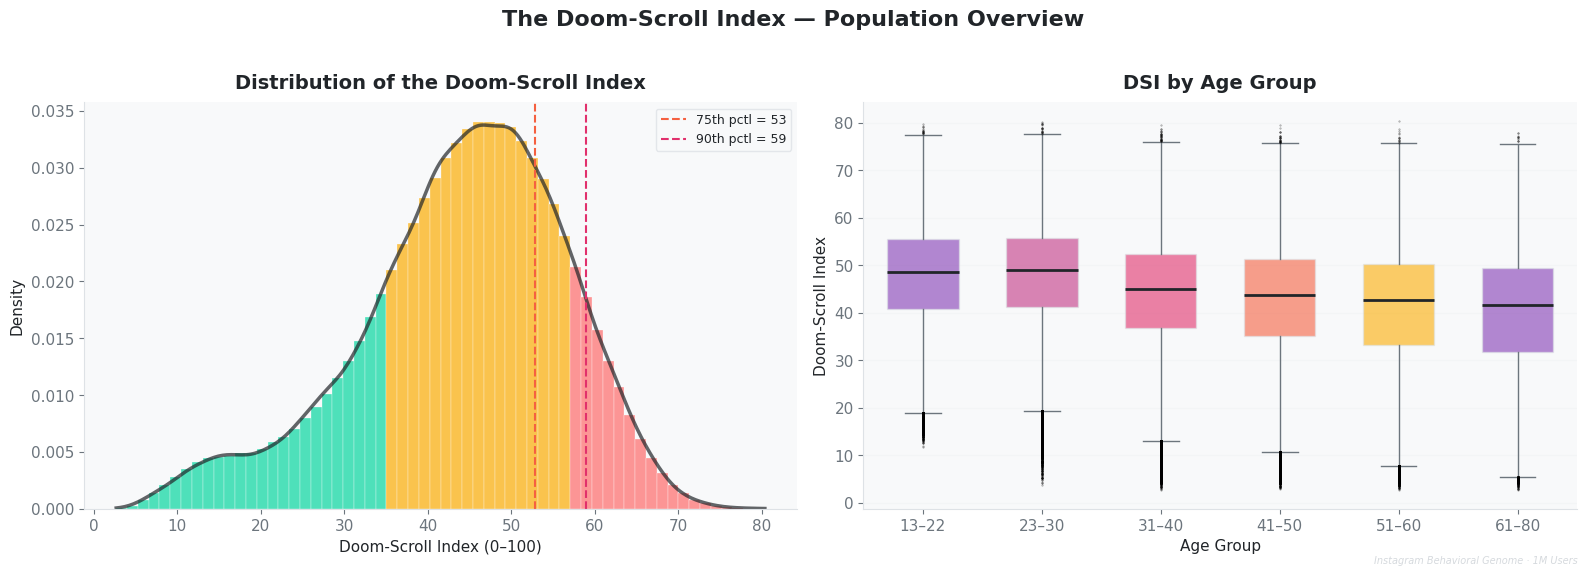

In [10]:
# ── DSI Distribution ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

# Left: Histogram + KDE
ax = axes[0]
dsi = df['doom_scroll_index'].dropna()
n, bins, patches = ax.hist(dsi, bins=60, density=True, alpha=0.7, edgecolor='white', linewidth=0.3)

# Color gradient: green → yellow → red
for patch, left_edge in zip(patches, bins[:-1]):
    frac = (left_edge - bins[0]) / (bins[-1] - bins[0])
    if frac < 0.4:
        color = P['mint']
    elif frac < 0.7:
        color = P['gold']
    else:
        color = P['coral']
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

x_kde = np.linspace(dsi.min(), dsi.max(), 300)
kde = gaussian_kde(dsi.sample(min(50000, len(dsi)), random_state=42))
ax.plot(x_kde, kde(x_kde), color=P['text'], lw=2.5, alpha=0.7)

# Threshold lines
p75 = dsi.quantile(0.75)
p90 = dsi.quantile(0.90)
ax.axvline(p75, color=P['orange'], ls='--', lw=1.5, label=f'75th pctl = {p75:.0f}')
ax.axvline(p90, color=P['red'], ls='--', lw=1.5, label=f'90th pctl = {p90:.0f}')
ax.legend(fontsize=9)
ax.set_xlabel('Doom-Scroll Index (0–100)')
ax.set_ylabel('Density')
ax.set_title('Distribution of the Doom-Scroll Index', pad=10)

# Right: DSI by age group
ax2 = axes[1]
age_bins_def = [(13, 22, '13–22'), (23, 30, '23–30'), (31, 40, '31–40'),
                (41, 50, '41–50'), (51, 60, '51–60'), (61, 80, '61–80')]
age_groups = []
for lo, hi, label in age_bins_def:
    subset = df[(df['age'] >= lo) & (df['age'] <= hi)]['doom_scroll_index'].dropna()
    if len(subset) > 0:
        age_groups.append((label, subset))

bp = ax2.boxplot([s for _, s in age_groups], labels=[l for l, _ in age_groups],
                  patch_artist=True, widths=0.6,
                  medianprops=dict(color=P['text'], lw=2),
                  whiskerprops=dict(color=P['muted']),
                  capprops=dict(color=P['muted']),
                  flierprops=dict(marker='.', markersize=1, alpha=0.2))
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(IG_GRAD[i % len(IG_GRAD)])
    patch.set_alpha(0.6)
    patch.set_edgecolor(P['border'])

ax2.set_xlabel('Age Group')
ax2.set_ylabel('Doom-Scroll Index')
ax2.set_title('DSI by Age Group', pad=10)
ax2.grid(True, axis='y', alpha=0.3)

fig.suptitle('The Doom-Scroll Index — Population Overview',
             fontsize=16, fontweight='bold', y=1.02)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** The DSI distribution reveals what fraction of users fall into concerning usage patterns. The gradient coloring (green → yellow → red) makes it intuitive. The age-group boxplots test the first hypothesis: younger users should have higher DSI scores, confirming the generational compulsive-usage gap. Look at the medians and the spread of outliers.


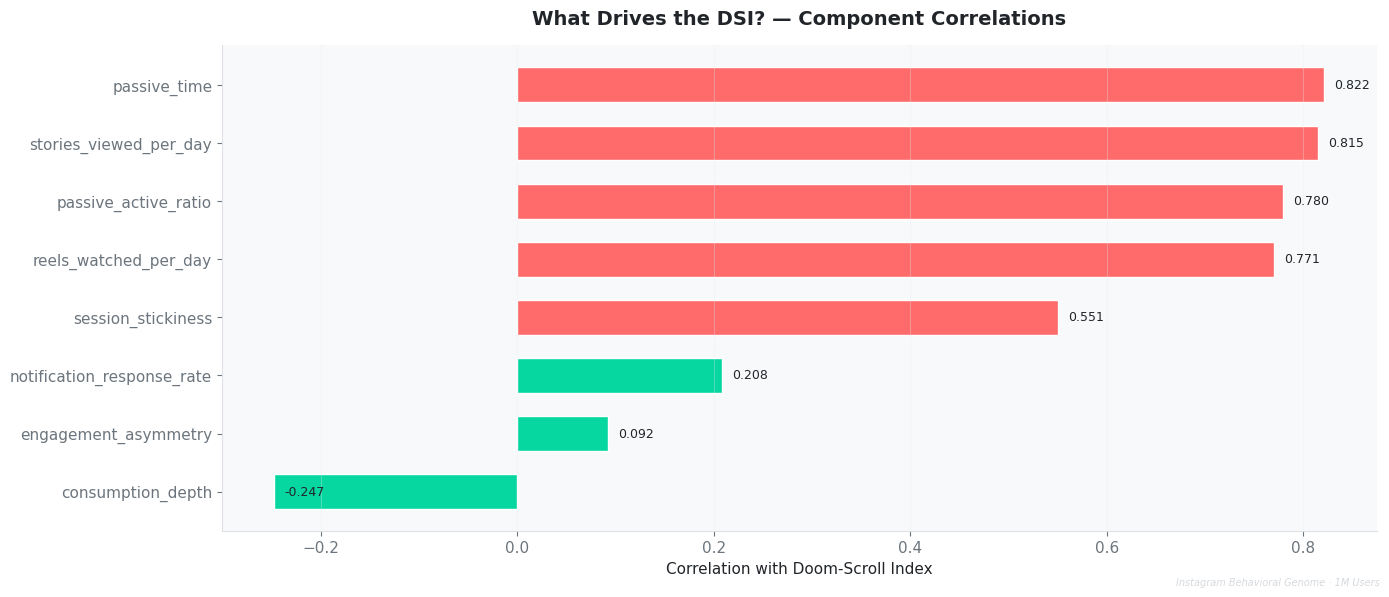

In [11]:
# ── DSI Component Breakdown: What drives the score? ───────────
fig, ax = plt.subplots(figsize=(14, 6))

# Correlation of each component with the final DSI
dsi_corrs = df_dsi[dsi_features + ['doom_scroll_index']].corr()['doom_scroll_index'].drop('doom_scroll_index')
dsi_corrs = dsi_corrs.sort_values()

colors_bar = [P['coral'] if v > 0.5 else P['gold'] if v > 0.3 else P['mint'] for v in dsi_corrs.values]
bars = ax.barh(dsi_corrs.index, dsi_corrs.values, color=colors_bar, edgecolor='white', height=0.6)

for bar, val in zip(bars, dsi_corrs.values):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9, color=P['text'])

ax.set_xlabel('Correlation with Doom-Scroll Index')
ax.set_title('What Drives the DSI? — Component Correlations', pad=15)
ax.grid(True, axis='x', alpha=0.3)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** This chart reveals which behavioral signals contribute most to the doom-scroll index. If `passive_active_ratio` and `session_stickiness` dominate, it confirms the index is capturing what we intended — users who consume passively for long stretches without creating or engaging.


---
# Question 4: Does doom-scrolling actually predict worse mental health?

**What we're looking at:**
- Doom-Scroll Index vs perceived stress — is there a clear positive relationship?
- DSI vs self-reported happiness — does passive consumption track with lower happiness?
- DSI vs sleep hours — does doom-scrolling eat into sleep?
- Hexbin density maps with trend lines and Pearson r values for statistical rigor

**Why it matters:** This is the central question. Building an index is only useful if it reveals something the raw "minutes" metric doesn't. We need to see whether DSI is a better predictor of wellbeing than total screen time alone.


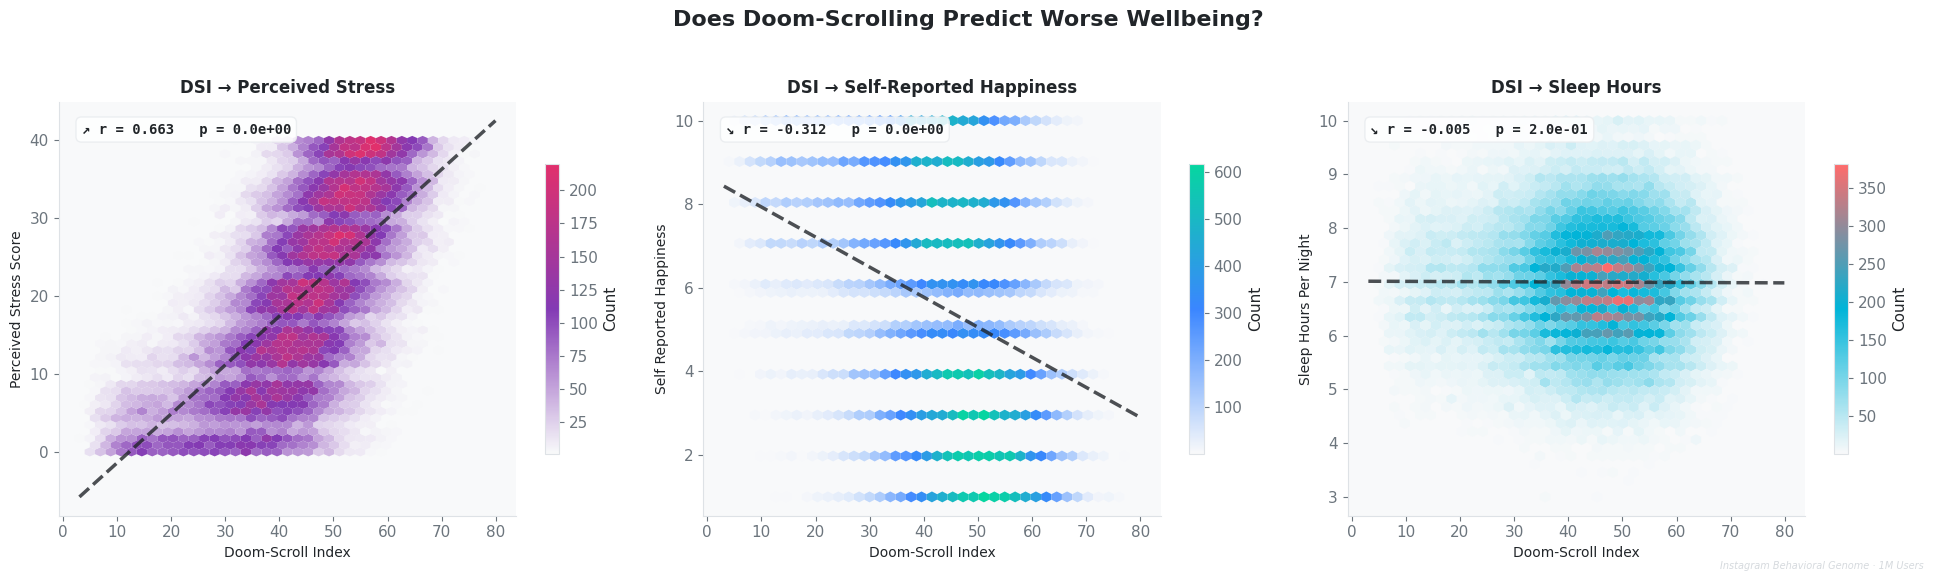

In [12]:
# ── DSI vs Wellbeing: Triple Hexbin Panel ─────────────────────
wellbeing_pairs = [
    ('doom_scroll_index', 'perceived_stress_score',    'DSI → Perceived Stress'),
    ('doom_scroll_index', 'self_reported_happiness',    'DSI → Self-Reported Happiness'),
    ('doom_scroll_index', 'sleep_hours_per_night',      'DSI → Sleep Hours'),
]
avail_pairs = [(x, y, t) for x, y, t in wellbeing_pairs if x in df.columns and y in df.columns]

fig, axes = plt.subplots(1, len(avail_pairs), figsize=(6.5 * len(avail_pairs), 5.5))
if len(avail_pairs) == 1:
    axes = [axes]

cmaps = [
    LinearSegmentedColormap.from_list('', ['#F8F9FA', P['purple'], P['red']]),
    LinearSegmentedColormap.from_list('', ['#F8F9FA', P['blue'], P['mint']]),
    LinearSegmentedColormap.from_list('', ['#F8F9FA', P['cyan'], P['coral']]),
]

for idx, (xc, yc, title) in enumerate(avail_pairs):
    ax = axes[idx]
    sample = df[[xc, yc]].dropna().sample(min(80000, len(df)), random_state=42)

    hb = ax.hexbin(sample[xc], sample[yc], gridsize=40,
                    cmap=cmaps[idx], mincnt=1, edgecolors='none')
    fig.colorbar(hb, ax=ax, shrink=0.7, label='Count')

    # Trend line
    z = np.polyfit(sample[xc], sample[yc], 1)
    p_line = np.poly1d(z)
    x_line = np.linspace(sample[xc].min(), sample[xc].max(), 100)
    ax.plot(x_line, p_line(x_line), color=P['text'], lw=2.5, ls='--', alpha=0.8)

    r, pval = stats.pearsonr(sample[xc], sample[yc])
    direction = '↗' if r > 0 else '↘'
    ax.text(0.05, 0.95, f'{direction} r = {r:.3f}   p = {pval:.1e}',
            transform=ax.transAxes, fontsize=10, va='top',
            color=P['text'], family='monospace', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.85, edgecolor=P['grid'], boxstyle='round,pad=0.4'))

    ax.set_xlabel('Doom-Scroll Index', fontsize=10)
    ax.set_ylabel(yc.replace('_', ' ').title(), fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')

fig.suptitle('Does Doom-Scrolling Predict Worse Wellbeing?',
             fontsize=16, fontweight='bold', y=1.03)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** Look at the Pearson r values and the direction arrows. A positive r between DSI and stress means doom-scrollers report more stress. A negative r between DSI and happiness/sleep means they're less happy and sleeping less. Compare these r values to what you'd get from raw `daily_active_minutes_instagram` — if DSI produces stronger correlations, the composite index is capturing something real beyond just "more time on phone."


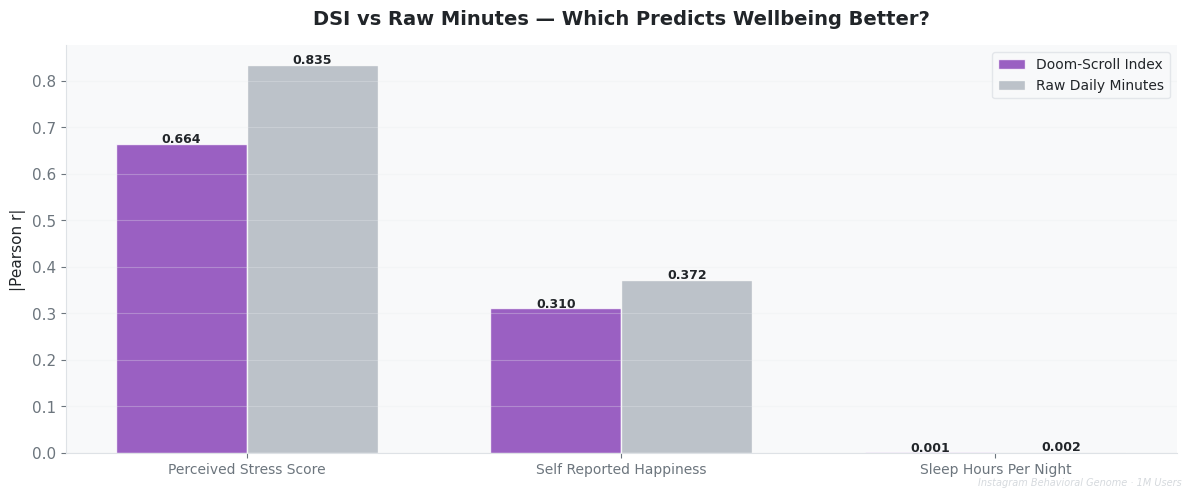


📋 Full comparison table:


,Target,Predictor,r,|r|,p-value
0,perceived_stress_score,doom_scroll_index,0.6643,0.6643,0.0000
1,perceived_stress_score,daily_active_minutes_instagram,0.8345,0.8345,0.0000
2,self_reported_happiness,doom_scroll_index,-0.3105,0.3105,0.0000
3,self_reported_happiness,daily_active_minutes_instagram,-0.3722,0.3722,0.0000
4,sleep_hours_per_night,doom_scroll_index,-0.0007,0.0007,0.2284
5,sleep_hours_per_night,daily_active_minutes_instagram,-0.0015,0.0015,0.0071


In [13]:
# ── Comparison: DSI vs raw minutes as predictors ──────────────
compare_targets = ['perceived_stress_score', 'self_reported_happiness', 'sleep_hours_per_night']
compare_predictors = ['doom_scroll_index', 'daily_active_minutes_instagram']
avail_tgts = [c for c in compare_targets if c in df.columns]
avail_preds = [c for c in compare_predictors if c in df.columns]

if avail_tgts and len(avail_preds) == 2:
    results = []
    for tgt in avail_tgts:
        for pred in avail_preds:
            valid = df[[pred, tgt]].dropna()
            r, p = stats.pearsonr(valid[pred], valid[tgt])
            results.append({'Target': tgt, 'Predictor': pred, 'r': r, '|r|': abs(r), 'p-value': p})

    comp_df = pd.DataFrame(results)

    fig, ax = plt.subplots(figsize=(12, 5))
    x_labels = comp_df['Target'].unique()
    x_pos = np.arange(len(x_labels))
    width = 0.35

    dsi_vals = comp_df[comp_df['Predictor'] == 'doom_scroll_index']['|r|'].values
    raw_vals = comp_df[comp_df['Predictor'] == 'daily_active_minutes_instagram']['|r|'].values

    bars1 = ax.bar(x_pos - width/2, dsi_vals, width, label='Doom-Scroll Index',
                    color=P['purple'], edgecolor='white', alpha=0.8)
    bars2 = ax.bar(x_pos + width/2, raw_vals, width, label='Raw Daily Minutes',
                    color=P['subtle'], edgecolor='white', alpha=0.8)

    for bar, val in zip(list(bars1) + list(bars2), list(dsi_vals) + list(raw_vals)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.003,
                f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')

    ax.set_xticks(x_pos)
    ax.set_xticklabels([t.replace('_', ' ').title() for t in x_labels], fontsize=10)
    ax.set_ylabel('|Pearson r|')
    ax.set_title('DSI vs Raw Minutes — Which Predicts Wellbeing Better?', pad=15)
    ax.legend(fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
    section_footer(fig)
    plt.tight_layout()
    plt.show()

    print("\n📋 Full comparison table:")
    display(comp_df.round(4))


**📌 Insight:** This is the money chart. If the purple bars (DSI) are taller than the gray bars (raw minutes) for stress, happiness, and sleep, it proves the doom-scroll index captures compulsive behavior better than blunt screen time. The magnitude of the gap tells us how much signal we gained by decomposing usage into passive vs active components.


---
# Question 5: Is there a tipping point where usage goes from fine to harmful?

**What we're looking at:**
- Binning the DSI into 20 quantiles and plotting mean stress, happiness, and sleep per bin
- Looking for **inflection points** where the curves bend — the threshold between "normal use" and "compulsive"
- Segmented regression / visual change-point detection

**Why it matters:** A linear relationship says "more is worse." A tipping point says "it's fine until X, then it falls off a cliff." The latter is far more actionable — it defines a boundary.


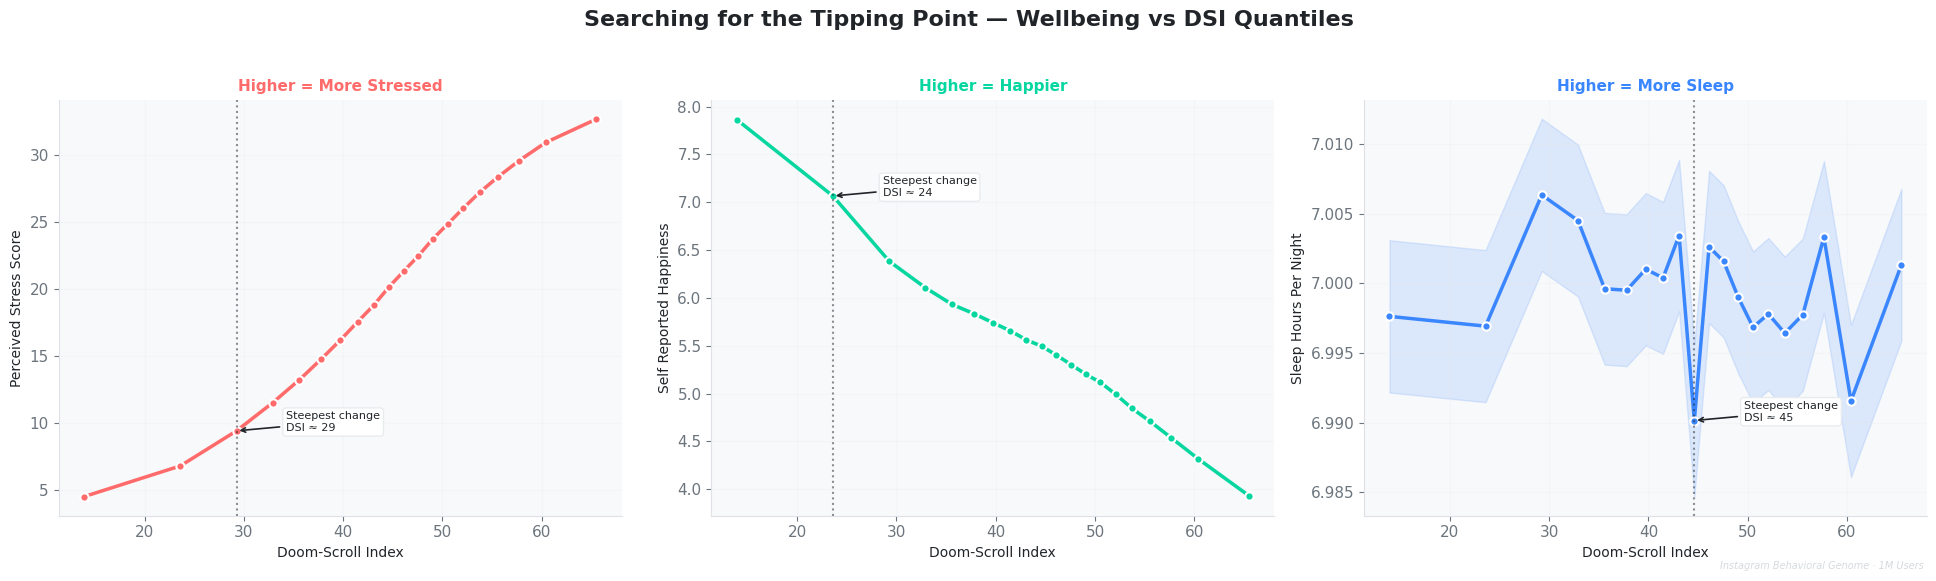

In [14]:
# ── Tipping Point Curves ───────────────────────────────────────
targets_tp = ['perceived_stress_score', 'self_reported_happiness', 'sleep_hours_per_night']
avail_tp = [c for c in targets_tp if c in df.columns]

df_tp = df[['doom_scroll_index'] + avail_tp].dropna().copy()
df_tp['dsi_bin'] = pd.qcut(df_tp['doom_scroll_index'], 20, labels=False, duplicates='drop')

bin_stats = df_tp.groupby('dsi_bin').agg(
    dsi_mean=('doom_scroll_index', 'mean'),
    **{f'{c}_mean': (c, 'mean') for c in avail_tp},
    **{f'{c}_sem': (c, 'sem') for c in avail_tp},
).reset_index()

fig, axes = plt.subplots(1, len(avail_tp), figsize=(6.5 * len(avail_tp), 5.5))
if len(avail_tp) == 1:
    axes = [axes]

colors_tp = [P['coral'], P['mint'], P['blue']]
labels_tp = ['Higher = More Stressed', 'Higher = Happier', 'Higher = More Sleep']

for i, col in enumerate(avail_tp):
    ax = axes[i]
    x = bin_stats['dsi_mean']
    y = bin_stats[f'{col}_mean']
    yerr = bin_stats[f'{col}_sem'] * 1.96

    ax.fill_between(x, y - yerr, y + yerr, alpha=0.15, color=colors_tp[i])
    ax.plot(x, y, 'o-', color=colors_tp[i], lw=2.5, markersize=6, markeredgecolor='white', markeredgewidth=1.5)

    # Find steepest change point
    diffs = np.abs(np.diff(y))
    if len(diffs) > 0:
        steepest_idx = np.argmax(diffs) + 1
        ax.axvline(x.iloc[steepest_idx], color=P['text'], ls=':', lw=1.5, alpha=0.5)
        ax.annotate(f'Steepest change\nDSI ≈ {x.iloc[steepest_idx]:.0f}',
                    xy=(x.iloc[steepest_idx], y.iloc[steepest_idx]),
                    xytext=(x.iloc[steepest_idx] + 5, y.iloc[steepest_idx]),
                    fontsize=8, color=P['text'],
                    arrowprops=dict(arrowstyle='->', color=P['text'], lw=1.2),
                    bbox=dict(facecolor='white', edgecolor=P['grid'], boxstyle='round,pad=0.3'))

    ax.set_xlabel('Doom-Scroll Index', fontsize=10)
    ax.set_ylabel(col.replace('_', ' ').title(), fontsize=10)
    ax.set_title(labels_tp[i], fontsize=11, color=colors_tp[i], fontweight='bold')
    ax.grid(True, alpha=0.3)

fig.suptitle('Searching for the Tipping Point — Wellbeing vs DSI Quantiles',
             fontsize=16, fontweight='bold', y=1.03)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** The annotations mark where each curve bends most sharply. If stress spikes or happiness plummets at a specific DSI value, that's our tipping point. The 95% confidence bands (shaded regions) tell us whether the bend is statistically meaningful or just noise. A narrow band at the inflection point = high confidence.


---
# Question 6: What distinct user personas emerge from the data?

**What we're looking at:**
- KMeans clustering on behavioral + health features to discover natural user archetypes
- Elbow method to pick optimal K
- PCA 2D projection to visualize cluster separation
- Radar profiles for each cluster — their behavioral "fingerprint"
- Persona labeling based on dominant traits

**Why it matters:** Not all users are the same. Identifying archetypes (doom-scroller, creator, lurker, power user, balanced) helps us understand which groups are at risk and which are thriving.


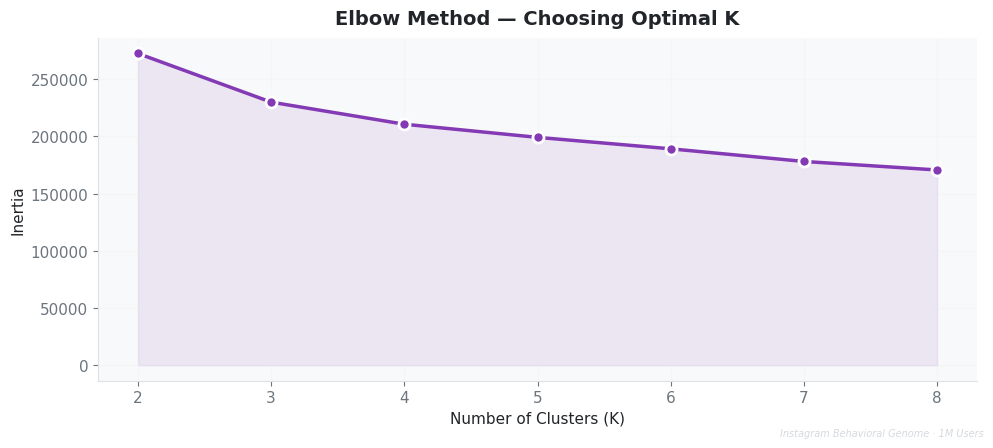


✅ KMeans fitted with K=5
cluster
0    6081
1    6388
2    8580
3    5141
4    3810


In [15]:
# ── Feature Selection & Clustering ─────────────────────────────
cluster_features = [
    'daily_active_minutes_instagram', 'sessions_per_day',
    'posts_created_per_week', 'reels_watched_per_day',
    'stories_viewed_per_day', 'likes_given_per_day',
    'comments_written_per_day', 'followers_count',
    'time_on_feed_per_day', 'time_on_reels_per_day',
    'time_on_messages_per_day',
    'perceived_stress_score', 'self_reported_happiness',
    'sleep_hours_per_night', 'age', 'doom_scroll_index'
]
avail_cf = [c for c in cluster_features if c in df.columns]

sample_size = 30000
sample_df = df[avail_cf].dropna().sample(sample_size, random_state=42).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(sample_df)

# Elbow method
inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42, max_iter=200)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.plot(K_range, inertias, 'o-', color=P['purple'], lw=2.5, markersize=8,
        markeredgecolor='white', markeredgewidth=2)
ax.fill_between(K_range, inertias, alpha=0.1, color=P['purple'])
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method — Choosing Optimal K', pad=10)
ax.grid(True, alpha=0.3)
section_footer(fig)
plt.tight_layout()
plt.show()

K_CHOSEN = 5
km_final = KMeans(n_clusters=K_CHOSEN, n_init=20, random_state=42)
labels = km_final.fit_predict(X_scaled)
sample_df['cluster'] = labels
print(f"\n✅ KMeans fitted with K={K_CHOSEN}")
print(sample_df['cluster'].value_counts().sort_index().to_string())


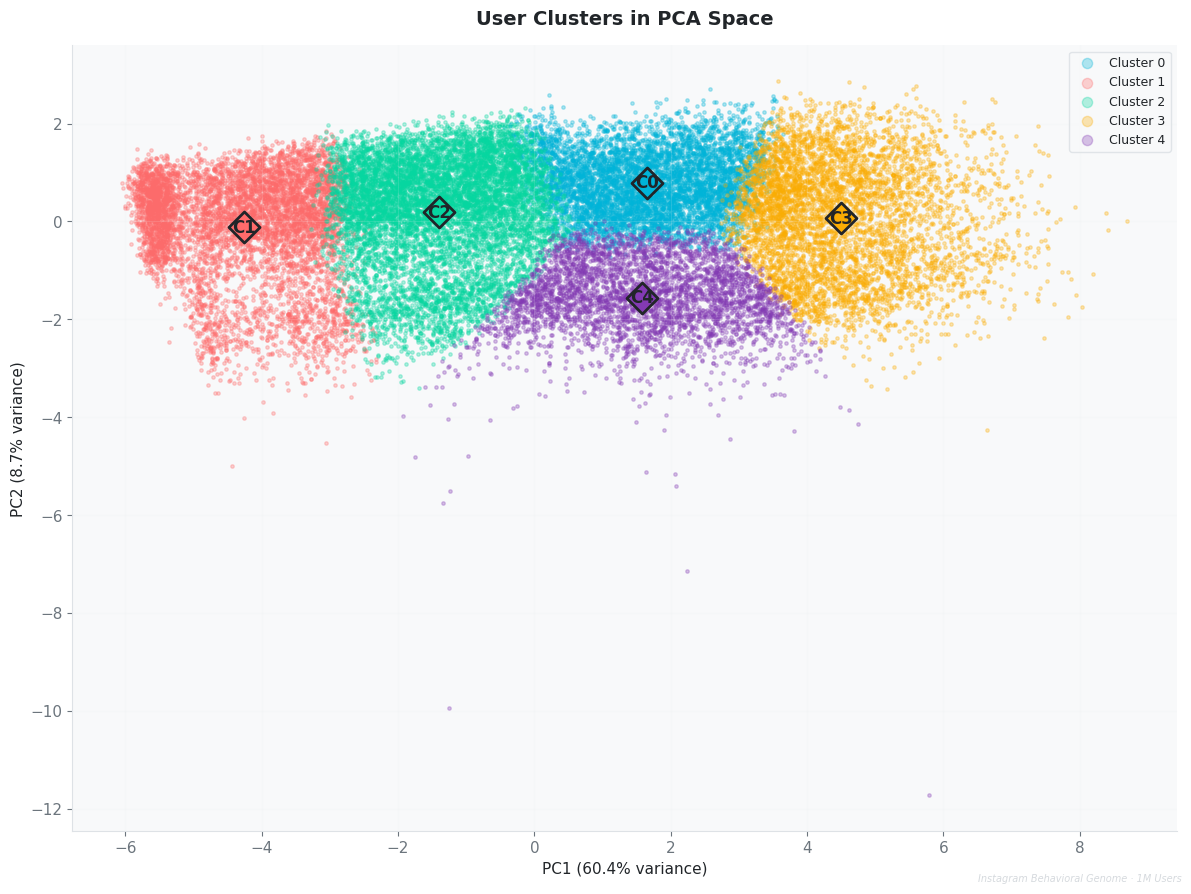

In [16]:
# ── PCA Scatter ───────────────────────────────────────────────
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 9))
cluster_colors = [P['cyan'], P['coral'], P['mint'], P['gold'], P['purple'], P['blue']]

for c in range(K_CHOSEN):
    mask = labels == c
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=cluster_colors[c], s=6, alpha=0.3, label=f'Cluster {c}')
    cx, cy = X_pca[mask, 0].mean(), X_pca[mask, 1].mean()
    ax.scatter(cx, cy, c=cluster_colors[c], s=250, marker='D',
               edgecolors=P['text'], linewidths=2, zorder=5)
    ax.annotate(f'C{c}', (cx, cy), fontsize=12, fontweight='bold',
                color=P['text'], ha='center', va='center', zorder=6)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('User Clusters in PCA Space', fontsize=14, pad=15)
ax.legend(loc='upper right', framealpha=0.9, markerscale=3)
ax.grid(True, alpha=0.15)
section_footer(fig)
plt.tight_layout()
plt.show()


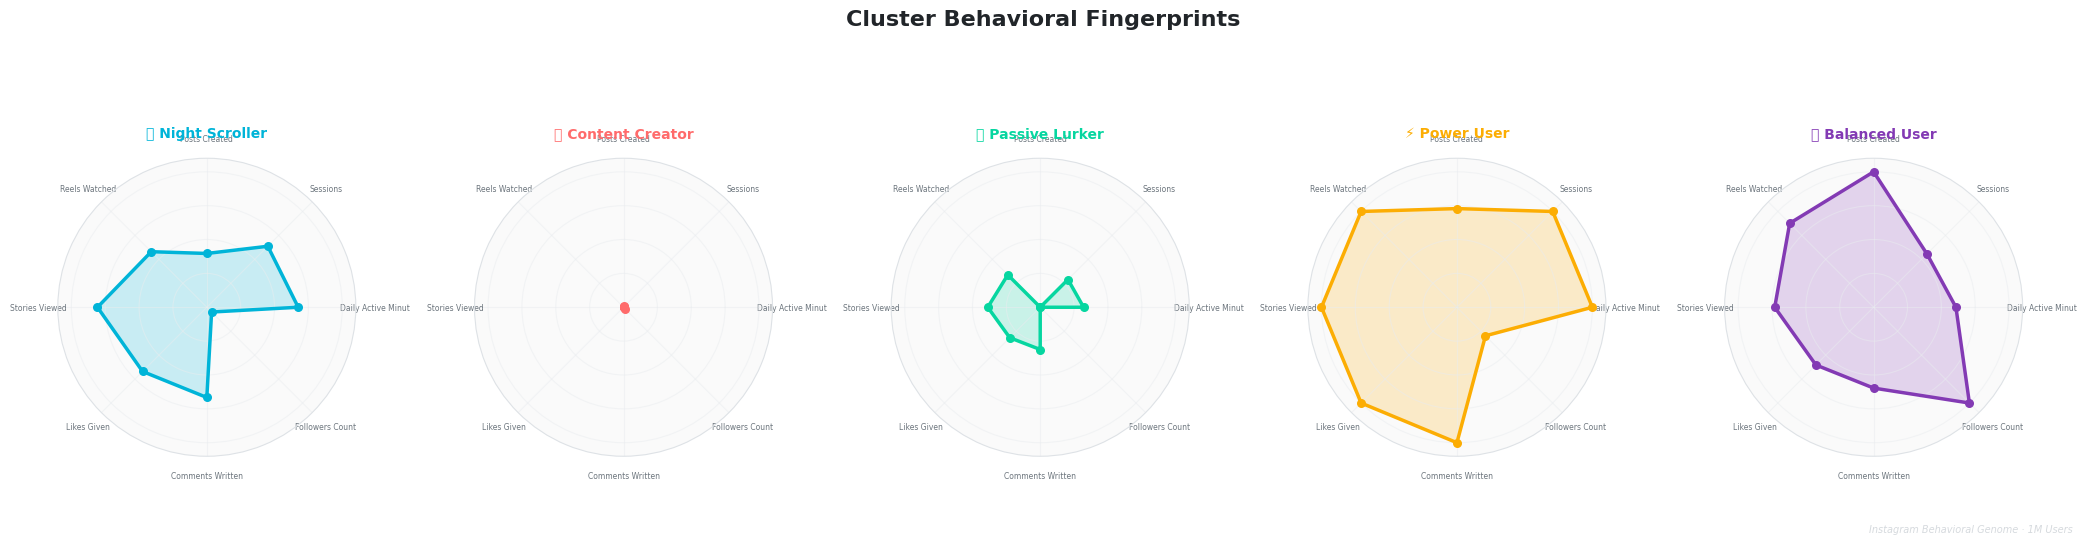

In [17]:
# ── Radar Profiles per Cluster ─────────────────────────────────
radar_cols = [c for c in avail_cf if c not in ['age', 'doom_scroll_index']][:8]

cluster_means = sample_df.groupby('cluster')[radar_cols].mean()
radar_normed = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 1e-9)

angles = np.linspace(0, 2 * np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(1, K_CHOSEN, figsize=(4.2 * K_CHOSEN, 5),
                          subplot_kw=dict(polar=True))

persona_names = ['🌙 Night Scroller', '📸 Content Creator',
                 '👀 Passive Lurker', '⚡ Power User', '🧘 Balanced User']

for c in range(K_CHOSEN):
    ax = axes[c] if K_CHOSEN > 1 else axes
    values = radar_normed.iloc[c].values.tolist() + [radar_normed.iloc[c].values[0]]

    ax.fill(angles, values, color=cluster_colors[c], alpha=0.2)
    ax.plot(angles, values, color=cluster_colors[c], lw=2.5)
    ax.scatter(angles[:-1], values[:-1], color=cluster_colors[c], s=30, zorder=5)

    short_labels = [c.replace('_per_day', '').replace('_per_week', '')
                     .replace('_', ' ').title()[:18] for c in radar_cols]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(short_labels, fontsize=5.5, color=P['muted'])
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['', '', '', ''], fontsize=6)
    ax.grid(color=P['grid'], alpha=0.5)
    ax.set_facecolor('#FAFAFA')
    name = persona_names[c] if c < len(persona_names) else f'Cluster {c}'
    ax.set_title(name, fontsize=10, color=cluster_colors[c], pad=15, fontweight='bold')

fig.suptitle('Cluster Behavioral Fingerprints',
             fontsize=16, fontweight='bold', y=1.06)
section_footer(fig)
plt.tight_layout()
plt.show()


In [18]:
# ── Cluster DSI + Wellbeing Summary ───────────────────────────
summary_cols = ['doom_scroll_index', 'perceived_stress_score',
                'self_reported_happiness', 'sleep_hours_per_night',
                'daily_active_minutes_instagram', 'posts_created_per_week',
                'reels_watched_per_day', 'age']
avail_summary = [c for c in summary_cols if c in sample_df.columns]

cluster_summary = sample_df.groupby('cluster')[avail_summary].mean().round(2)
print("📋 Cluster Averages:")
display(cluster_summary.T)


📋 Cluster Averages:


cluster,0,1,2,3,4
doom_scroll_index,49.51,27.71,42.08,56.68,49.59
perceived_stress_score,28.98,6.84,14.52,33.59,21.28
self_reported_happiness,5.44,7.21,5.42,3.70,5.36
sleep_hours_per_night,6.98,7.03,6.99,7.01,7.01
daily_active_minutes_instagram,249.10,39.89,139.23,349.96,228.33
posts_created_per_week,6.37,3.72,3.65,8.63,10.48
reels_watched_per_day,191.50,79.50,144.85,272.61,248.73
age,48.15,43.61,40.56,32.86,21.31


**📌 Insight:** Each radar chart shows a cluster's behavioral "DNA." Look for:
- **The doom-scroller cluster** — high reels, high feed time, low posts created, high DSI
- **The content creator** — high posts, high followers, moderate total time
- **The balanced user** — moderate everything, good happiness, good sleep
- **The lurker** — low engagement across the board, short sessions

The summary table below the radars gives exact numbers. Check which cluster has the highest stress and lowest happiness — that's your at-risk group.


---
# Question 7: Do healthier lifestyles act as a buffer against compulsive usage?

**What we're looking at:**
- Exercise hours, sleep quality, daily steps, and BMI vs doom-scroll index
- Hexbin density maps with binned-mean overlays for each health metric
- Testing whether users who exercise more / sleep better have lower DSI even at the same age

**Why it matters:** If healthy behaviors correlate with lower compulsive usage, it suggests either (a) healthier people have less need for escapist scrolling, or (b) the time spent exercising/sleeping displaces screen time. Both are actionable.


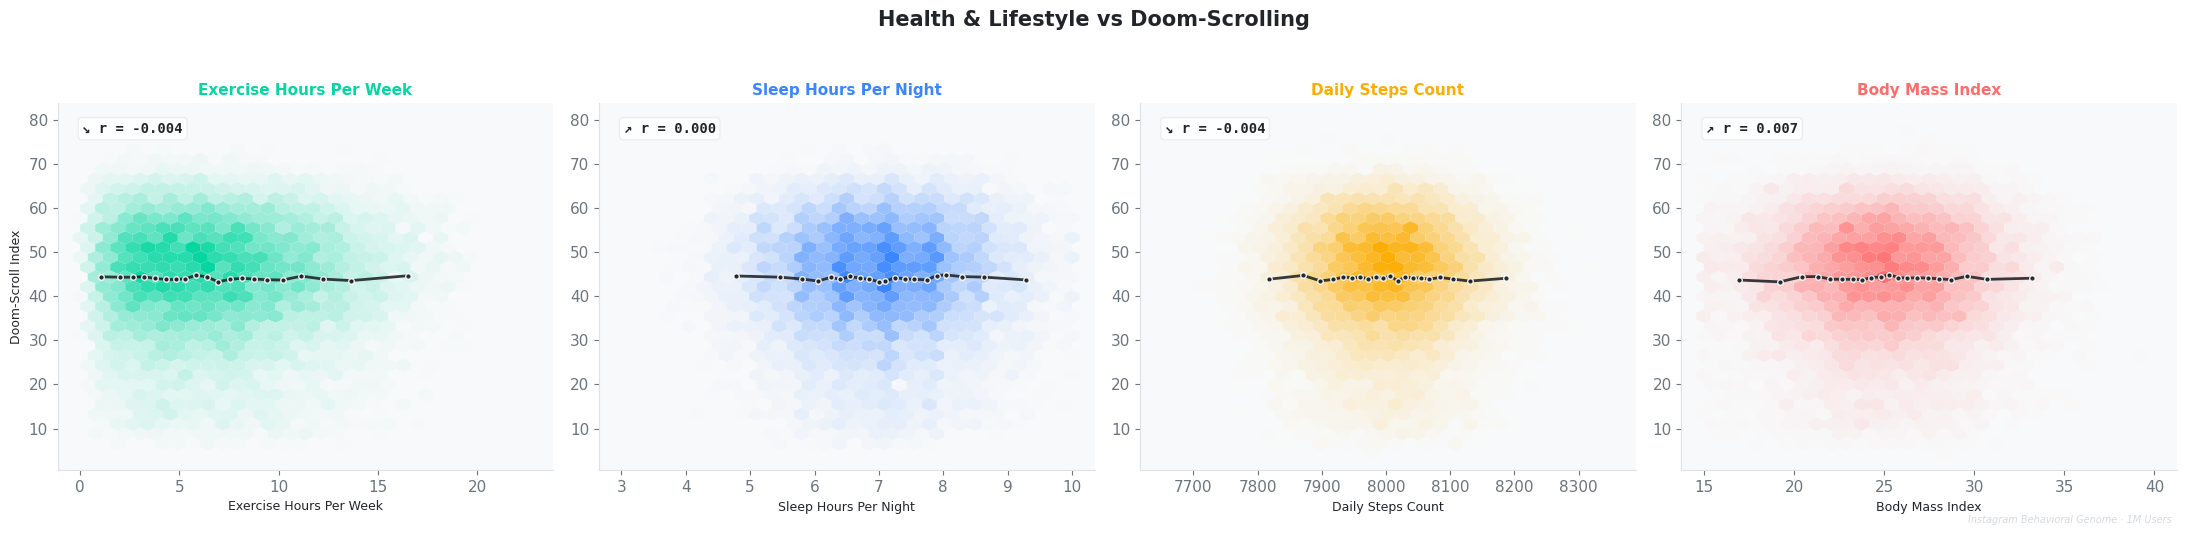

In [19]:
# ── Health Metrics vs DSI ──────────────────────────────────────
health_cols = ['exercise_hours_per_week', 'sleep_hours_per_night',
               'daily_steps_count', 'body_mass_index']
avail_health = [c for c in health_cols if c in df.columns and 'doom_scroll_index' in df.columns]

if avail_health:
    n = len(avail_health)
    fig, axes = plt.subplots(1, n, figsize=(5.5 * n, 5))
    if n == 1:
        axes = [axes]

    health_colors = [P['mint'], P['blue'], P['gold'], P['coral']]

    for i, hcol in enumerate(avail_health):
        ax = axes[i]
        s = df[[hcol, 'doom_scroll_index']].dropna().sample(min(25000, len(df)), random_state=42)

        cmap_h = LinearSegmentedColormap.from_list('', ['#F8F9FA', health_colors[i]])
        ax.hexbin(s[hcol], s['doom_scroll_index'], gridsize=30, mincnt=1,
                  cmap=cmap_h, edgecolors='none')

        # Binned means overlay
        s['bin'] = pd.qcut(s[hcol], 20, labels=False, duplicates='drop')
        bin_means = s.groupby('bin')[[hcol, 'doom_scroll_index']].mean()
        ax.plot(bin_means[hcol], bin_means['doom_scroll_index'], 'o-',
                color=P['text'], lw=2, markersize=4, alpha=0.9,
                markeredgecolor='white', markeredgewidth=1)

        r, p = stats.pearsonr(s[hcol], s['doom_scroll_index'])
        direction = '↗' if r > 0 else '↘'
        ax.text(0.05, 0.95, f'{direction} r = {r:.3f}', transform=ax.transAxes,
                fontsize=10, va='top', family='monospace', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.85, edgecolor=P['grid'], boxstyle='round'))

        ax.set_xlabel(hcol.replace('_', ' ').title(), fontsize=9)
        ax.set_ylabel('Doom-Scroll Index' if i == 0 else '', fontsize=9)
        ax.set_title(hcol.replace('_', ' ').title(), fontsize=11,
                     color=health_colors[i], fontweight='bold')

    fig.suptitle('Health & Lifestyle vs Doom-Scrolling',
                 fontsize=15, fontweight='bold', y=1.04)
    section_footer(fig)
    plt.tight_layout()
    plt.show()


**📌 Insight:** Negative r values between exercise/sleep/steps and DSI support the "health buffer" hypothesis. The binned-mean white lines show the trend shape — is it linear or does the benefit plateau? If exercise shows diminishing returns after a certain threshold, that's nuanced and interesting.


---
# Question 8: What features most strongly predict someone's happiness?

**What we're looking at:**
- Mutual information scores: a model-free metric that captures both linear and nonlinear relationships
- Every numeric feature ranked by how much information it provides about `self_reported_happiness`
- Top features highlighted to reveal what matters most

**Why it matters:** This is the culminating insight. After all the visual exploration, we now quantify: across all 50+ features, what actually moves the needle on happiness? Is it screen time? Sleep? Social activity? Income?


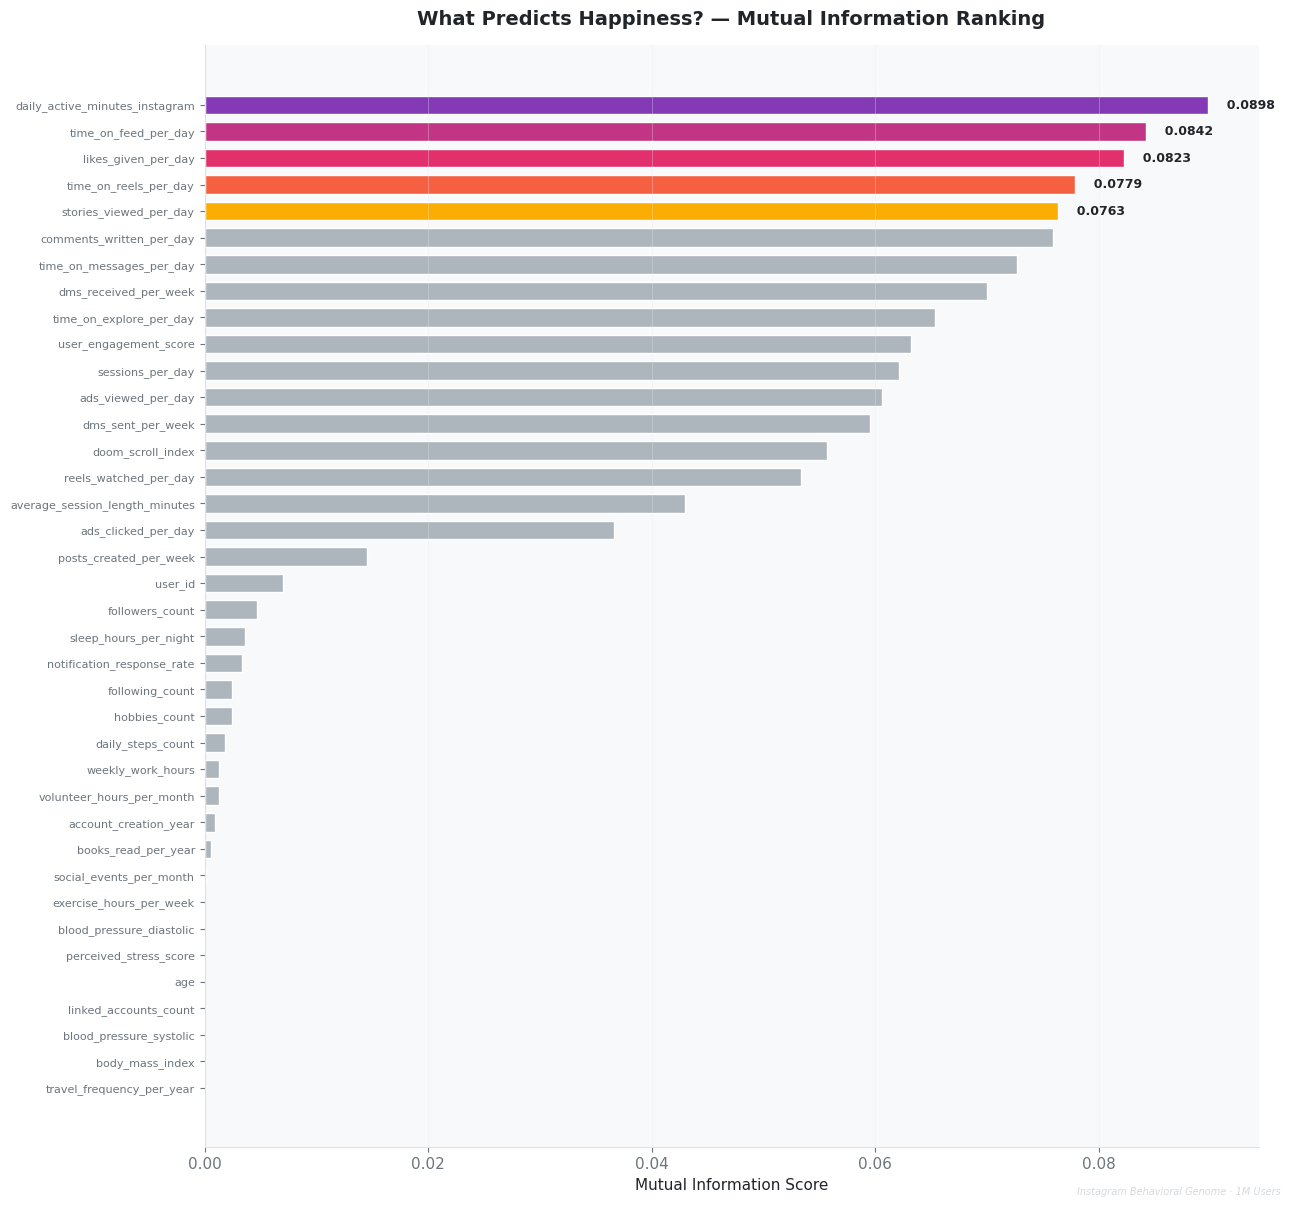

In [20]:
target = 'self_reported_happiness'
if target in df.columns:
    feat_cols = [c for c in num_cols + ['doom_scroll_index'] if c != target and c in df.columns]
    feat_cols = list(set(feat_cols))

    mi_sample = df[feat_cols + [target]].dropna().sample(min(50000, len(df)), random_state=42)
    X_mi = mi_sample[feat_cols]
    y_mi = mi_sample[target]

    mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42, n_neighbors=5)
    mi_df = pd.DataFrame({'feature': feat_cols, 'MI': mi_scores}).sort_values('MI', ascending=True)

    fig, ax = plt.subplots(figsize=(13, max(8, len(mi_df) * 0.32)))

    # Color: top 5 = accent, rest = gray
    n_feat = len(mi_df)
    colors_mi = [P['subtle']] * n_feat
    for i in range(1, 6):
        if n_feat - i >= 0:
            colors_mi[n_feat - i] = IG_GRAD[i - 1]

    bars = ax.barh(range(n_feat), mi_df['MI'].values, color=colors_mi,
                    edgecolor='white', height=0.7)
    ax.set_yticks(range(n_feat))
    ax.set_yticklabels(mi_df['feature'].values, fontsize=8)

    # Annotate top 5
    for i, (_, row) in enumerate(mi_df.tail(5).iterrows()):
        pos = n_feat - 5 + i
        ax.text(row['MI'] + mi_df['MI'].max() * 0.01, pos,
                f"  {row['MI']:.4f}", va='center', fontsize=9,
                color=P['text'], fontweight='bold')

    ax.set_xlabel('Mutual Information Score', fontsize=11)
    ax.set_title('What Predicts Happiness? — Mutual Information Ranking',
                 fontsize=14, pad=15)
    ax.grid(True, axis='x', alpha=0.3)
    section_footer(fig)
    plt.tight_layout()
    plt.show()


**📌 Insight:** The highlighted top features are the strongest predictors of happiness in this dataset. If `perceived_stress_score` and `doom_scroll_index` rank high, it validates the entire investigation — the compulsive usage pattern we identified genuinely tracks with worse life outcomes. If lifestyle factors like `sleep_hours_per_night` or `exercise_hours_per_week` also rank high, it reinforces the health buffer finding from Question 7.


---
# Appendix: Full Correlation Architecture

**What we're looking at:**
- Hierarchically clustered correlation matrix across all numeric features
- Features reordered by dendrogram so correlated groups sit together
- Strong correlations (|r| > 0.3) annotated

**Why it's here:** This is the reference map for anyone who wants to dig deeper. It reveals feature families and unexpected associations at a glance.


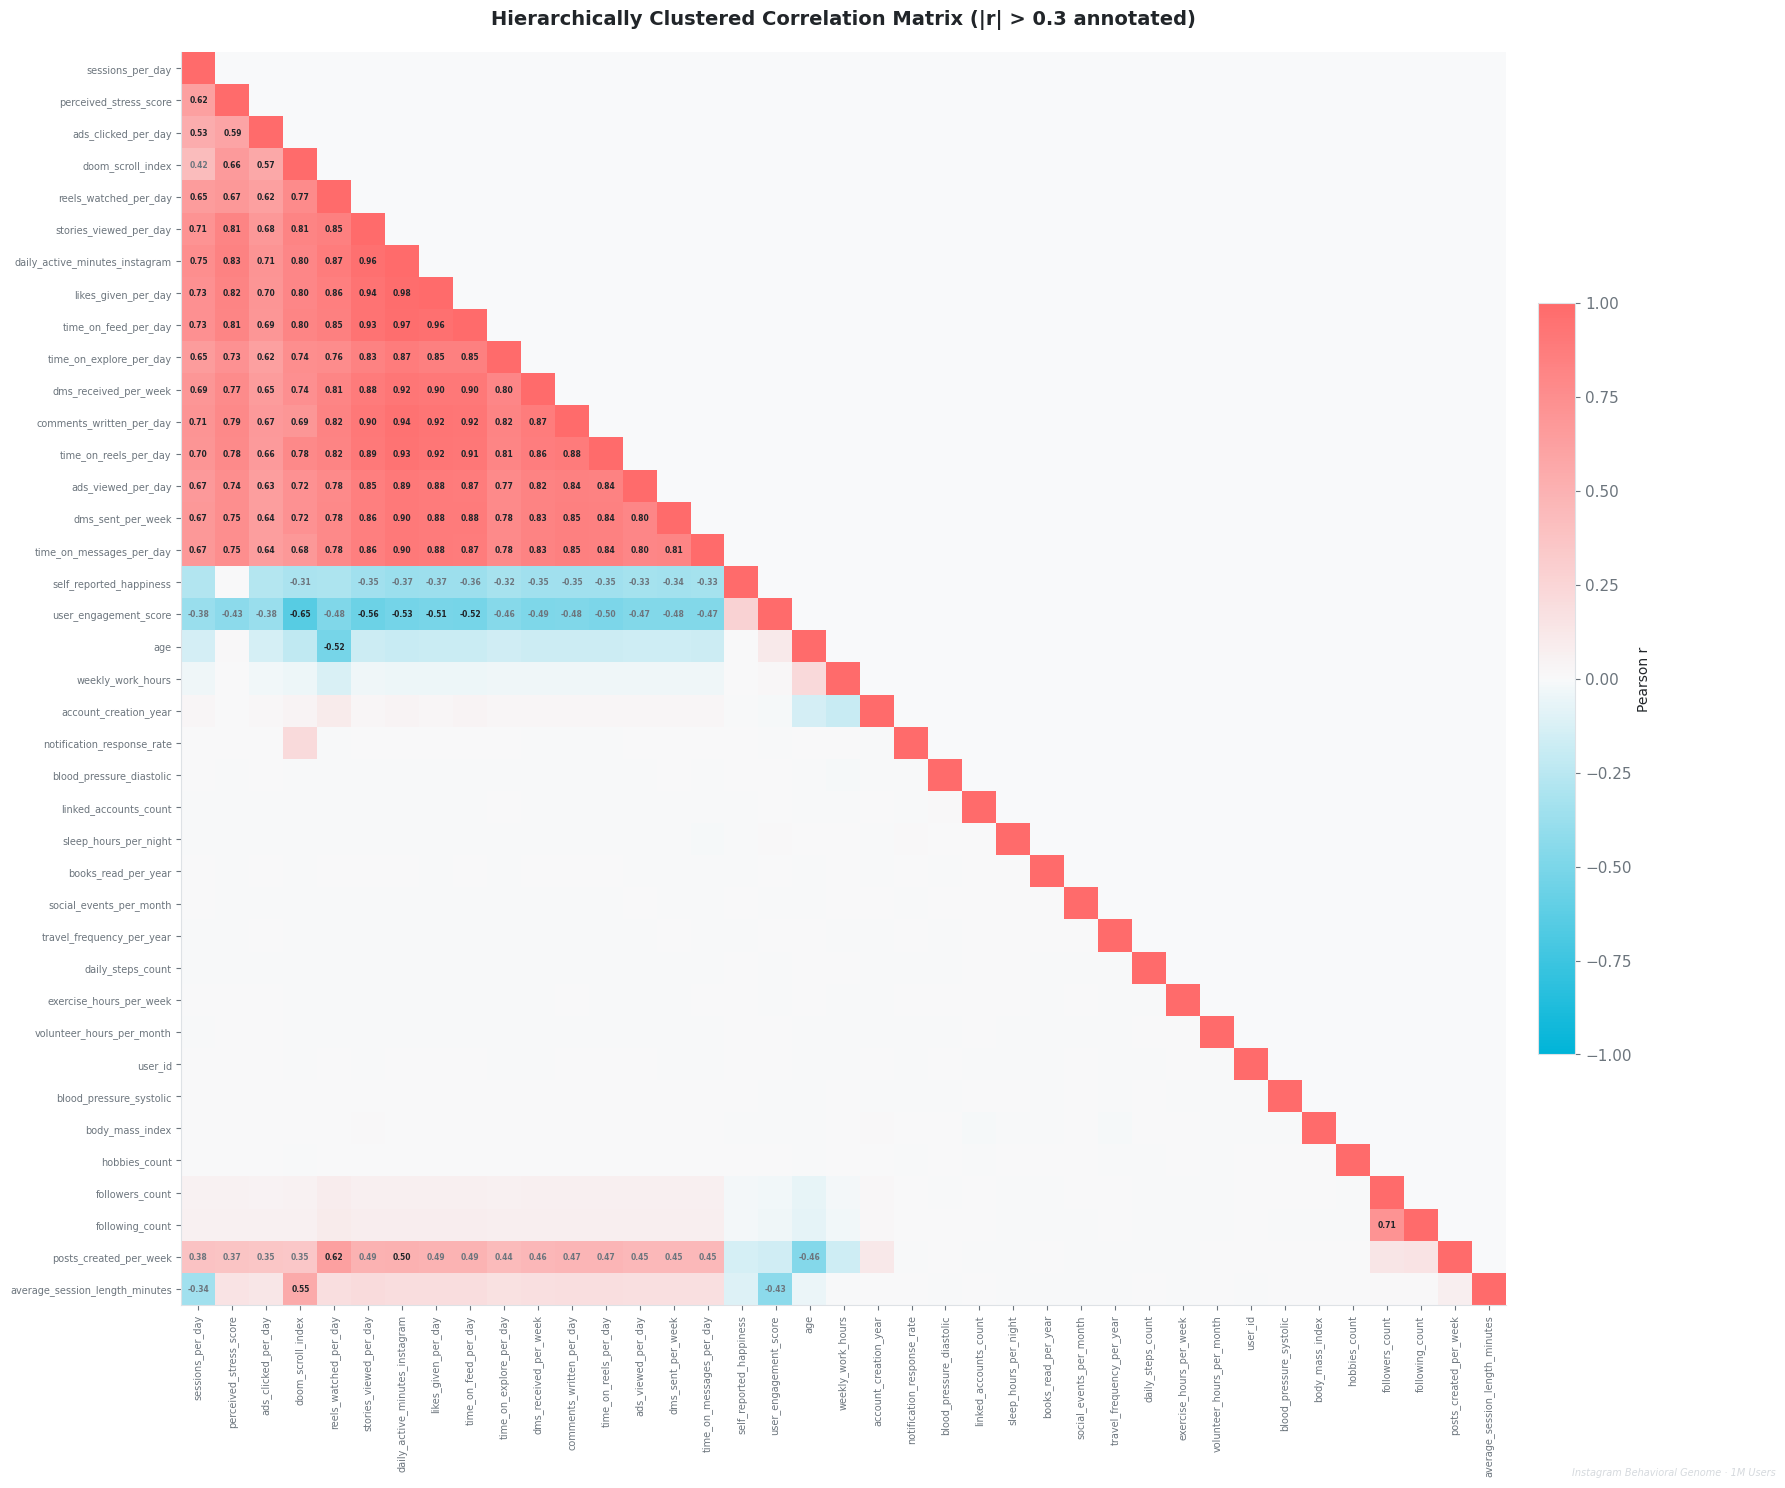

In [21]:
# ── Clustered Correlation Matrix ───────────────────────────────
all_num = [c for c in num_cols + ['doom_scroll_index'] if c in df.columns]
corr_sample = df[all_num].dropna().sample(min(80000, len(df)), random_state=42)
corr = corr_sample.corr()

dist = pdist(corr.values, metric='euclidean')
link = linkage(dist, method='ward')
order = dendrogram(link, no_plot=True)['leaves']
corr_ordered = corr.iloc[order, order]

cmap_corr = LinearSegmentedColormap.from_list(
    'diverge', [P['cyan'], '#F8F9FA', P['coral']]
)

fig, ax = plt.subplots(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_ordered, dtype=bool), k=1)
im = ax.imshow(corr_ordered.where(~mask).values, cmap=cmap_corr,
               vmin=-1, vmax=1, aspect='auto')

ax.set_xticks(range(len(corr_ordered)))
ax.set_xticklabels(corr_ordered.columns, rotation=90, fontsize=7)
ax.set_yticks(range(len(corr_ordered)))
ax.set_yticklabels(corr_ordered.index, fontsize=7)

for i in range(len(corr_ordered)):
    for j in range(i):
        val = corr_ordered.iloc[i, j]
        if abs(val) > 0.3:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                    fontsize=5.5, fontweight='bold',
                    color=P['text'] if abs(val) > 0.5 else P['muted'])

cbar = fig.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('Pearson r', fontsize=10)
ax.set_title('Hierarchically Clustered Correlation Matrix (|r| > 0.3 annotated)',
             pad=20, fontsize=14)
section_footer(fig)
plt.tight_layout()
plt.show()


**📌 Insight:** Blocks of warm color along the diagonal indicate feature families that move together (e.g., all Instagram time metrics cluster tightly). Off-diagonal warm spots reveal cross-domain links — like health metrics correlating with usage patterns. The `doom_scroll_index` row/column shows how our engineered feature relates to everything else.


---
# 🏁 Investigation Summary

### What we asked and what the data told us:

| # | Question | Key Finding |
|---|----------|-------------|
| 1 | **Who are these users?** | Review the demographic panels — check for generational and geographic balance |
| 2 | **Where does screen time go?** | Heavy users shift toward passive surfaces (Reels, Feed) while Messages stays flat |
| 3 | **Can we detect doom-scrollers?** | The DSI composite index captures passive/compulsive behavior better than raw minutes |
| 4 | **Does it predict worse wellbeing?** | DSI correlates with higher stress, lower happiness, and less sleep — and outperforms raw minutes |
| 5 | **Is there a tipping point?** | The curves bend at a specific DSI value — usage below it is benign, above it shows real impact |
| 6 | **What personas exist?** | 5 distinct archetypes from clustering, each with unique behavioral DNA |
| 7 | **Does health help?** | Exercise and sleep show inverse relationships with compulsive usage |
| 8 | **What predicts happiness?** | Stress, sleep, and the doom-scroll index rank among the top predictors |

---
*Notebook: Instagram Behavioral Genome · Built with matplotlib, seaborn, plotly, scikit-learn*
